Before starting, we load the standard Python data science and machine learning packages. In addition, we include the ExtendedLinearRegression class and variance inflation factor function I wrote for Lab 2. As with Lab 2, I will do the computations using both StatsModels and scikit-learn to demonstrate both approaches.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the LinearRegression class from scikit-learn's linear_model module
# Also load the PolynomialFeatures transformer and OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

# Load the stats module from scipy so we can code the functions to compute model statistics
from scipy import stats

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would load statsmodels.formula.api instead
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
class ExtendedLinearRegression(LinearRegression):
    
    def detailed_linear_regression(self, X, y):
        """
        Assume X is array-like with shape (num_samples, num_features)
        Assume y is array-like with shape (num_samples, num_targets)
        include_intercept is a boolean where True means X does not already have a column
        for the intercept
        Computes the least-squares regression model and returns a dictionary consisting of
        the fitted linear regression object; a series with the residual standard error,
        R^2 value, and the overall F-statistic with corresponding p-value; and a dataframe
        with columns for the parameters, and their corresponding standard errors,
        t-statistics, and p-values.
        """
        # Create a linear regression object and fit it using x and y
        self.training_X, self.training_y = X, y
        self.fit(X, y)
    
        # Store the parameters (regression intercept (if present) and coefficients) and predictions
        if(self.intercept_ != 0):
            self.params = np.append(self.intercept_, self.coef_)
        else:
            self.params = self.coef_.flatten()
        predictions = self.predict(X)
    
        # Create matrix with shape (num_samples, num_features + 1)
        # Where the first column is all 1s (if there is an intercept) and then there is one column for the values
        # of each feature/predictor
        if(self.intercept_ != 0):
            X_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
        else:
            X_mat = X
    
        # Compute residual sum of squares
        self.RSS = np.sum((y - predictions)**2)
    
        # Compute total sum of squares
        self.TSS = np.sum((np.mean(y) - y)**2)
    
        # Estimate the variance of the y-values
        obs_var = self.RSS/(X_mat.shape[0] - X_mat.shape[1])
    
        # Residual standard error is square root of variance of y-values
        self.RSE = obs_var**0.5
    
        # Variances of the parameter estimates are on the diagonal of the 
        # variance-covariance matrix of the parameter estimates
        self.var_beta_mat = obs_var*(np.linalg.inv(np.matmul(X_mat.T, X_mat)))
        self.var_beta = self.var_beta_mat.diagonal()
    
        # Standard error is square root of variance
        self.se_beta = np.sqrt(self.var_beta)
    
        # t-statistic for beta_i is beta_i/se_i, 
        # where se_i is the standard error for beta_i
        t_stats_beta = self.params/self.se_beta
    
        # Compute p-values for each parameter using a t-distribution with
        # (num_samples - 1) degrees of freedom
        beta_p_values = [2 * (1 - stats.t.cdf(np.abs(t_i), X_mat.shape[0] - 1)) for t_i in t_stats_beta]
    
        # Compute value of overall F-statistic, to measure how likely our
        # coefficient estimate are, assuming there is no relationship between
        # the predictors and the response
        if(self.intercept_ != 0):
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1] - 1))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1] - 1, X_mat.shape[0] - X_mat.shape[1])
        else:
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1]))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1], X_mat.shape[0] - X_mat.shape[1])
    
        # Construct dataframe for the overall model statistics:
        # RSE, R^2, F-statistic, p-value for F-statistic
        oa_model_stats = pd.Series({"Residual standard error": self.RSE, "R-squared": self.score(X, y), "F-statistic": self.F_overall, "F-test p-value": self.F_p_value})
    
        # Construct dataframe for parameter statistics:
        # coefficients, standard errors, t-statistic, p-values for t-statistics
        param_stats = pd.DataFrame({"Coefficient": self.params, "Standard Error": self.se_beta, "t-value": t_stats_beta, "Prob(>|t|)": beta_p_values})
        return {"model": self, "param_stats": param_stats, "oa_stats": oa_model_stats}
    
    def param_conf_int(self, level = 0.95):
        """
        Assume level, if given, is a float with 0 < level < 1
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        conf_intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each parameter
        for i in range(len(self.params)):
            coeff = self.params[i]
            std_err = self.se_beta[i]
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = estimated coefficient value
            # scale = standard error in coefficient estimate
            conf_intervals = conf_intervals.append(pd.DataFrame([stats.t.interval(level, df, loc = coeff, scale = std_err)], columns = [a, b]), ignore_index = True)
        return conf_intervals
    
    def predict_intervals(self, X_pred, level = 0.95, kind = "confidence"):
        """
        Assume X_pred is array-like with shape (num_predictions, num_features) with x-values for which we want predictions
        Assume level, if given, is a float with 0 < level < 1
        Assume kind, if given is either the string "confidence" or "prediction" for the kind of interval
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        # Store predictions for easy access
        predictions = self.predict(X_pred)
        intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each x-value being used for prediction
        for i in range(len(predictions)):
            prediction = predictions[i]
            # Need to append the leading 1 since our matrix of regression parameter
            # Estimates has first row the estimate for the constant
            x_star = np.append(np.ones(1), X_pred[i])
            conf_error = np.matmul(np.matmul(x_star.T, self.var_beta_mat), x_star)**0.5
            predict_error = (self.RSE**2 + conf_error**2)**0.5
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = predicted value from linear regression model
            # scale = standard error in predicted value estimate
            if (kind == "confidence"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = conf_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True) 
            elif(kind == "prediction"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = predict_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True)
        return intervals

In [3]:
def vif(predictors):
    """
    Assumes predictors is a Pandas dataframe with at least two columns
    Returns a Pandas series containing the variance inflation factor for each column variable
    """
    columns = predictors.columns
    vif_series = pd.Series()
    for col_name in columns:
        X = predictors.drop(columns = [col_name]).values
        y = predictors[col_name].values.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        r_sq = reg.score(X, y)
        vif_series[col_name] = 1/(1 - r_sq)
    return vif_series

# Applied Exercise 1

**This question involves the use of simple linear regression on the `Auto` data set.**

In [4]:
auto_filepath = "Auto.csv"
Auto = pd.read_csv(auto_filepath, na_values = ["?"]).dropna()

## Part 1
**Perform a simple linear regression with `mpg` as the response and `horsepower` as the predictor. Use then print the results. Comment on the output. For example:**

1. **Is there a relationship between the predictor and the response.**
2. **How strong is the relationship between the predictor and the response?**
3. **Is the relationship between the predictor and the response positive or negative.**
4. **What is the predicted `mpg` associated with a `horsepower` of 98? What are the associated 95% confidence and prediction intervals?**

First I do the computations using `smf.ols()` to use R-style formulas in StatsModels. Then I use my ExtendedLinearRegression class to do the computations with scikit-learn.

In [5]:
mod = smf.ols(formula = "mpg ~ horsepower", data = Auto)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           7.03e-81
Time:                        16:09:40   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

In [6]:
X = Auto["horsepower"].values.reshape(-1, 1)
y = Auto["mpg"].values.reshape(-1, 1)
extended_reg = ExtendedLinearRegression()
detailed_regression_stats = extended_reg.detailed_linear_regression(X, y)

In [7]:
np.round(detailed_regression_stats["param_stats"], 6)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,39.935861,0.717499,55.659841,0.0
1,-0.157845,0.006446,-24.489135,0.0


In [8]:
np.round(detailed_regression_stats["oa_stats"], 6)

Residual standard error      4.905757
R-squared                    0.605948
F-statistic                599.717741
F-test p-value               0.000000
dtype: float64

Simple linear regression gives a model $\hat{Y} = 39.935861 - 0.157845X_1$ between the predictor `horsepower` and the response `mpg`. A p-value of essentially zero for $\hat{\beta}_1 = -0.157845$ gives very strong evidence that there is a relationship between `mpg` and `horsepower`. Since $R^2 = 0.6059$, approximately 60.6% of the variability in `mpg` is explained by a linear regression onto `horsepower`. This is a modest relationship between the predictor and the response, since as discussed in the chapter we can improve  our $R^2$ value to 0.688 by including a quadratic term. The value of $\hat{\beta}_1$ itself indicates that in the model each increase of 1 horsepower results on average in a decrease of 0.157845 miles per gallon. In other words, in this model there is a negative relationship between the predictor and the response. 

In [9]:
# Performing prediction and generating confidence, prediction intervals for horsepower = 98 using StatsModels
res.predict(pd.DataFrame({"horsepower": [98]}))

0    24.467077
dtype: float64

In [10]:
reg_predictions = res.get_prediction(pd.DataFrame({"horsepower": [98]}))

In [11]:
pd.DataFrame(reg_predictions.conf_int(alpha = 0.05), columns = ["2.5%", "97.5%"])

,2.5%,97.5%
0,23.973079,24.961075


In [12]:
pd.DataFrame(reg_predictions.conf_int(obs = True, alpha = 0.05), columns = ["2.5%", "97.5%"])

,2.5%,97.5%
0,14.809396,34.124758


In [13]:
# Generating 95% confidence interval for prediction for horsepower = 98 using ExtendedLinearRegression
extended_reg.predict_intervals([[98]], level = 0.95, kind = "confidence")

,2.5%,97.5%,prediction
0,23.973079,24.961075,24.467077


In [14]:
# Generating 95% confidence interval for prediction for horsepower = 98 using ExtendedLinearRegression
extended_reg.predict_intervals([[98]], level = 0.95, kind = "prediction")

,2.5%,97.5%,prediction
0,14.809396,34.124758,24.467077


Plugging in a `horsepower` value of 98 gives a predicted `mpg` of 24.46708. The 95% confidence interval for this prediction is (23.97308, 24.96108) and the 95% prediction interval is (14.8094, 34.12467)

## Part 2
**Plot the response and the predictor. Make sure to display the least squares regression line.**

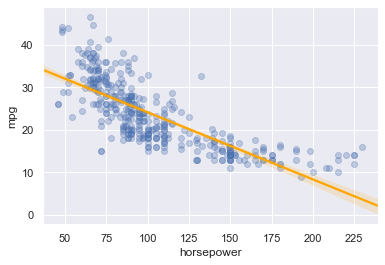

In [15]:
# First using regplot() from Seaborn
sns.regplot(x = "horsepower", y = "mpg", data = Auto, scatter_kws = {"alpha": 0.3}, line_kws = {"color": "orange"})

[Text(0, 0.5, 'mpg'), (43.699999999999996, 241.5), Text(0.5, 0, 'horsepower')]

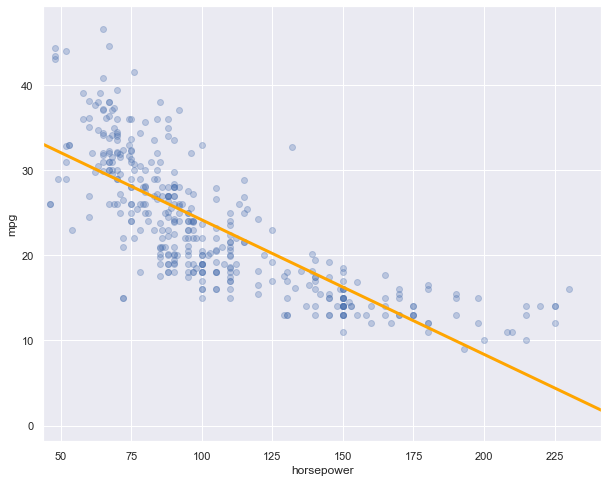

In [16]:
# Plotting by hand using scikit-learn

x = np.linspace(0, 250, num = 100).reshape(-1, 1)
predictions = extended_reg.predict(x)
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()

# Plot the regression line in orange with a line width of 3 to increase visibility
ax.plot(x, predictions, color = "orange", linewidth = 3)

# Plot the scatterplot with an alpha value of 0.3 for the markers to reduce clutter
ax.scatter(Auto["horsepower"], Auto["mpg"], alpha = 0.3)

# Give the plot some labels that are more descriptive
ax.set(xlabel = "horsepower", ylabel = "mpg", xlim = (Auto["horsepower"].min()*0.95, Auto["horsepower"].max()*1.05))

## Part 3
**Produce diagnostic plots (e.g. Residuals vs. Fitted; Residuals vs. Leverage; etc) of the least squares regression fit. Comment on any problems you see with the fit.**

[(-2.9110363399029273, 3.631853965362482),
 Text(0, 0.5, 'Studentized residuals'),
 (0, 0.03272830197001358),
 Text(0.5, 0, 'Leverage'),
 Text(0.5, 1.0, 'Residuals vs. Leverage')]

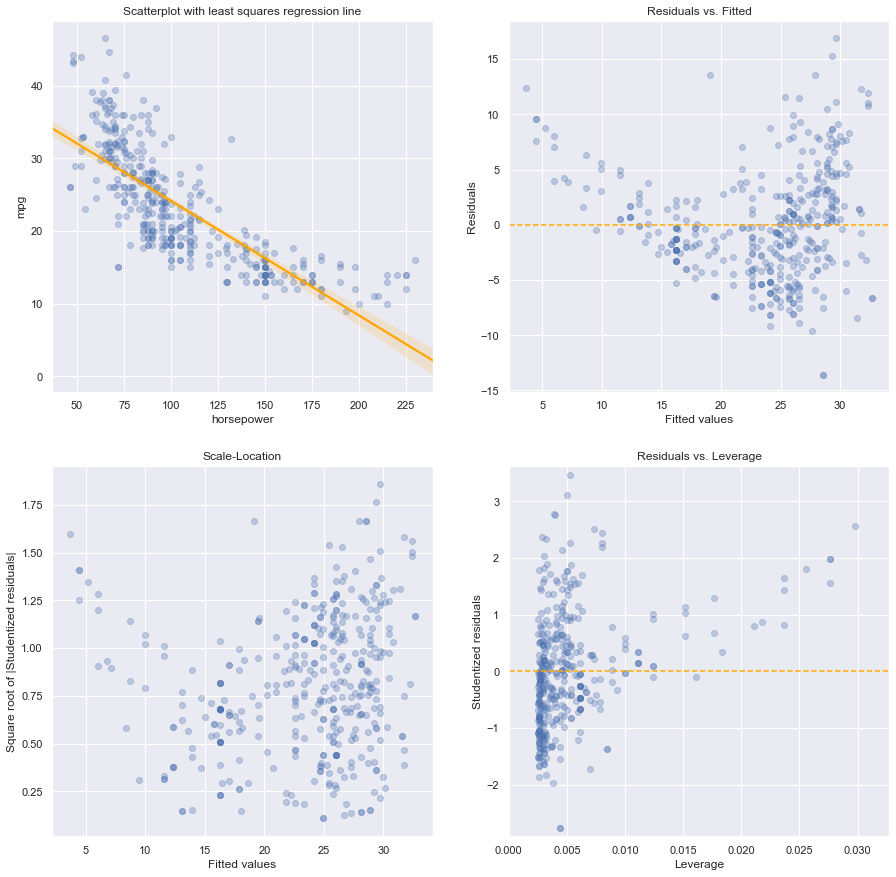

In [17]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand

# Compute residuals
predicted_mpg = extended_reg.predict(X)
residuals = (y - predicted_mpg).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones(X.shape), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Scatterplot of data with least squares regression line
sns.regplot(x = "horsepower", y = "mpg", data = Auto, scatter_kws = {"alpha": 0.3}, line_kws = {"color": "orange"},
           ax = axes[0, 0])
axes[0, 0].set(title = "Scatterplot with least squares regression line")
# Plot for residuals vs. fitted value
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(predicted_mpg, residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predicted_mpg, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[1, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[1, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[1, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

Looking at the Residuals vs. Fitted plot, there is a clear U-shape to the residuals, which is a strong indicator of non-linearity in the data. This, when combined with an inspection of the plot in Part 2, tells us that the simple linear regression model is not a good fit. In addition, when looking at the Residuals vs. Leverage plot, there are some high leverage points (remember that after dropping the rows with null values, there are 392 observations in the data set, giving an average leverage value of $2/392 \approx 0.0051$) which also have high standardized residual values (greater than 2), which is also of concern for the simple linear regression model. There are also a number of observations with a standardized residual value of 3 or more, which is evidence to suggest that they would be possibile outliers if we didn't already have the suspicion that the data is non-linear.

# Applied Exercise 2

**This question involves the use of multiple linear regression on the `Auto` data set.**

In [18]:
auto_filepath = "Auto.csv"
Auto = pd.read_csv(auto_filepath, na_values = ["?"]).dropna()
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Note that the `origin` column actually contains categorical data, even though it is coded using integers. In order to make my life a little easier for performing regression, I'm going replace the values in that column with their meanings. There are also other options for coding categorical variables, such as using the `C()` function within [StatsModels when using R-style formulas](http://www.statsmodels.org/stable/contrasts.html) to have more control over the contrast coding or specifying the categories in scikit-learn's [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [19]:
Auto.origin[Auto.origin == 1] = "American"
Auto.origin[Auto.origin == 2] = "European"
Auto.origin[Auto.origin == 3] = "Japanese"
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino


## Part 1
**Produce a scatterplot matrix which includes all of the variables in the data set.**

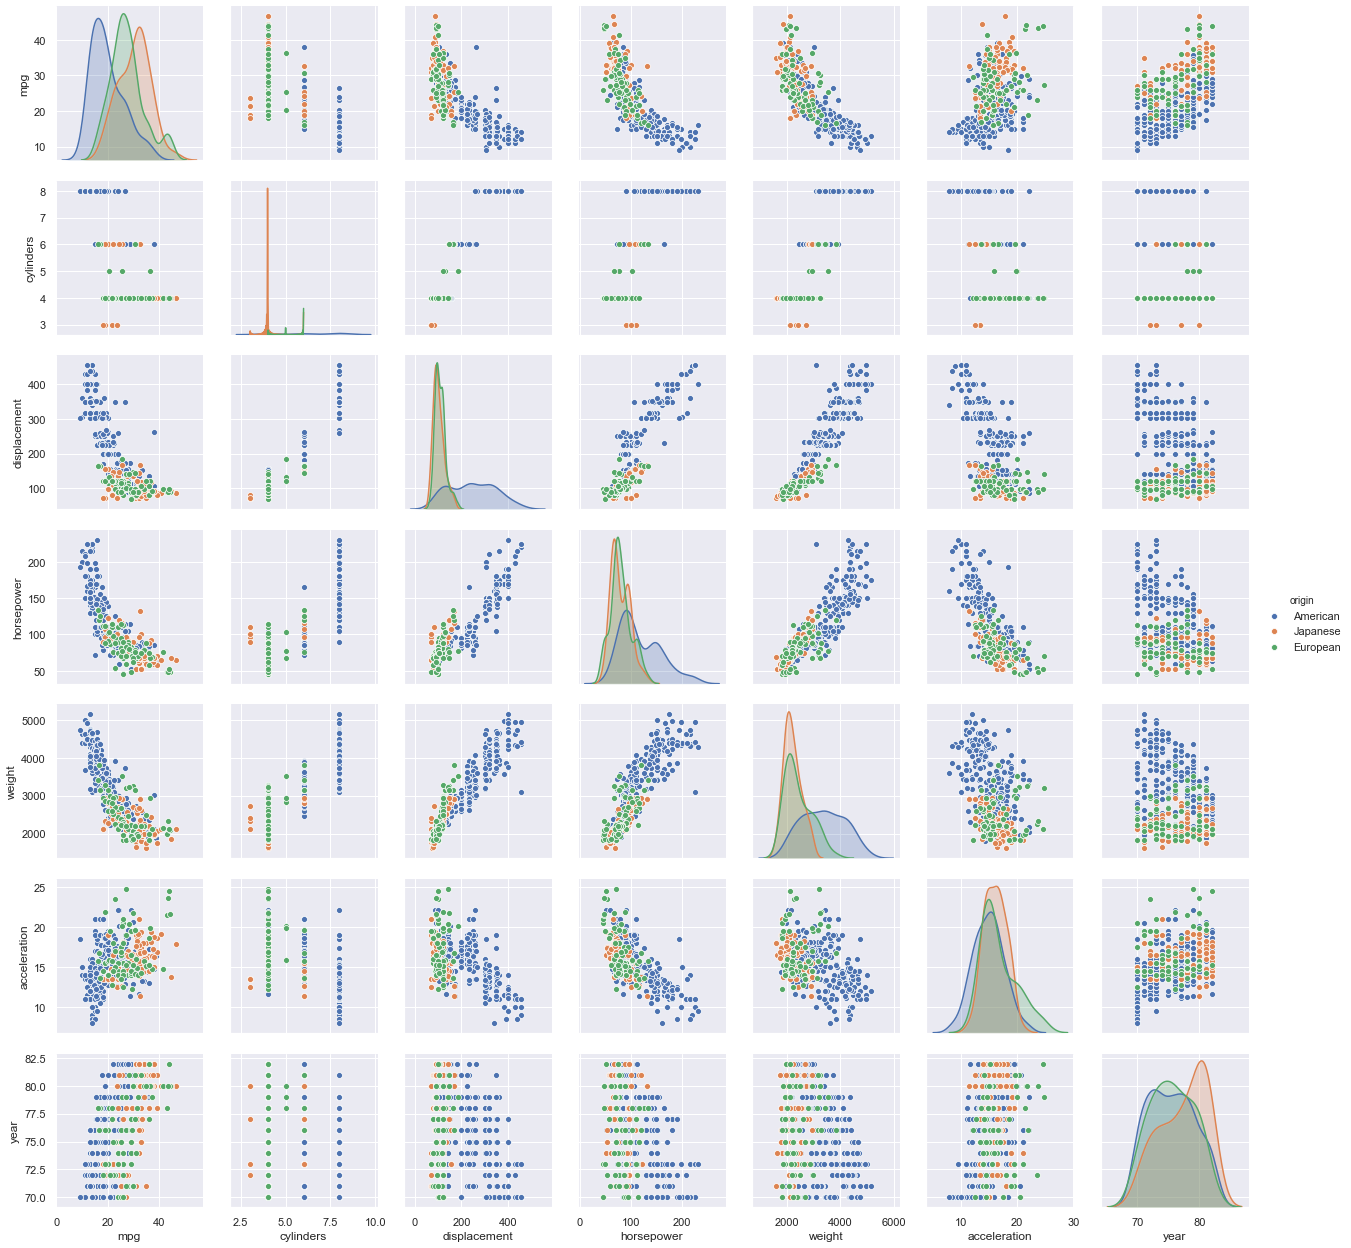

In [20]:
sns.pairplot(Auto.drop(columns = ["name"]), hue = "origin")

Since `name` is categorical column, I'm excluding it from the scatterplot matrix. I'm using `origin` to set the hue in order to visually highlight the differences between American, Japanese, and European cars.

## Part 2

**Compute the matrix of correlations between the variables using the Pandas function `corr()`. It will automatically exclude the `origin` and `name` columns since they are qualitative.**

In [21]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000


## Part 3
**Perform a multiple linear regression with `mpg` as the response and all other variables except `name` as the predictors. Print the results and comment on the output. For instance:**
1. **Is there a relationship between the predictors and the response?**
2. **Which predictors appear to have a statistically significant relationship to the response?**
3. **What does the coefficient for the `year` variable suggest?**

In [22]:
# Using R-style formulas in StatsModels
columns = "+".join(Auto.columns.drop(["mpg", "name"]))
formula = "mpg ~ " + columns
mod_all = smf.ols(formula = formula, data = Auto)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Wed, 18 Dec 2019   Prob (F-statistic):          1.79e-139
Time:                        16:10:13   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -17.9546      4

In [23]:
reg_all = ExtendedLinearRegression()

# Encode categorical predictors using OneHotEncoder
# Set the categories and drop the first category when encoding to use reduced-rank coding
# This then replicates the default behavior of how Patsy and R do categorical encoding
enc = OneHotEncoder(categories = [["American", "European", "Japanese"]], drop = "first")
cat_pred = enc.fit_transform(Auto["origin"].values.reshape(-1, 1)).toarray()
cat_pred = pd.DataFrame(cat_pred, columns = ["originEuropean", "originJapanese"])
quant_pred = Auto.drop(columns = ["origin", "name", "mpg"]).reset_index(drop = True)

# Combine all of the columns into a single dataframe of predictors
# Note that we needed to reset the index for quant_pred in order to have it align with the indices
# for the other columns when joining
# We could avoid this if we worked purely with the underlying NumPy arrays
X = cat_pred.join([quant_pred])
y = Auto["mpg"].values.reshape(-1, 1)
stats_all = reg_all.detailed_linear_regression(X, y)

In [24]:
stats_all["param_stats"].set_index(X.columns.insert(0, "intercept"))

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,-17.954602,4.676934,-3.838969,1.440608e-04
originEuropean,2.630002,0.566415,4.643246,4.690682e-06
originJapanese,2.853228,0.552736,5.162006,3.896681e-07
cylinders,-0.489709,0.321231,-1.524478,1.281977e-01
displacement,0.023979,0.007653,3.133124,1.859906e-03
horsepower,-0.018183,0.013709,-1.326428,1.854723e-01
weight,-0.006710,0.000655,-10.242779,0.000000e+00
acceleration,0.079103,0.098218,0.805378,4.210910e-01
year,0.777027,0.051784,15.005130,0.000000e+00


In [25]:
np.round(stats_all["oa_stats"], 4)

Residual standard error      3.3065
R-squared                    0.8242
F-statistic                224.4507
F-test p-value               0.0000
dtype: float64

Since the F-statistic is 224.5, giving a p-value of essentially zero for the null hypothesis $H_0: \beta_j = 0 \text{ for all } j$, there is strong evidence to believe that there is a relationship between the predictors and the response. The predictors that appear to have a statistically significant relationship to the response `mpg` are `displacement` with a p-value of 0.001863, and `weight`, `year`, `originEuropean`, and `originJapanese` with p-values of essentially zero. The coefficients for `cylinders`, `horsepower`, and `acceleration` have p-values which are not small enough to provide evidence of a statistically significant relationship to the response `mpg`. The coefficient of 0.777 for the `year` variable suggests that when we fix the number of engine cylinders, engine displacement, horsepower, weight, acceleration, and country of origin, fuel efficiency increases on average by about 0.777 miles per gallon each year. In other words, the model suggests that we would expect cars from 1971 to be more fuel efficient by 0.777 miles per gallon on average compared to equivalent cars from 1970. Also of interest are the coefficients for `originEuropean` and `originJapanese`, which suggest that compared to equivalent cars from the United States, we would expect European cars to be more fuel efficient by 2.630 miles per gallon on average, and Japanese cars to be more fuel efficient by 2.853 miles per gallon on average. Lastly, the $R^2$ value of 0.8242 indicates that about 82% of the variation in `mpg` is explained by this least squares regression model.

Before moving on to Part 4, let's also explore collinearity in this fit, since matrix of correlations in Part 2 revealed that a number of variables were highly correlated with each other. We'll focus on just the quantitative variables.

In [26]:
vif(Auto.drop(columns = ["mpg", "origin", "name"]))

cylinders       10.633049
displacement    19.641683
horsepower       9.398043
weight          10.731681
acceleration     2.625581
year             1.244829
dtype: float64

As we can see, `cylinders`, `horsepower`, and `weight` each have variance inflation factors of approximately 10, while `displacement` has a variance inflation factor of almost 20. This, combined with the large in absolute value correlation values between those variables, provides strong evidence that there is a fair amount of multicollinearity between those four predictors. This makes sense when considering that the number of cylinders, engine displacement, and horsepower are closely related as characteristics of the car's engine, which also contributes a fair proportion of a car's weight.

## Part 4

**Use the `plot()` function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?**

(0.0, 1.0, 0.0, 1.0)

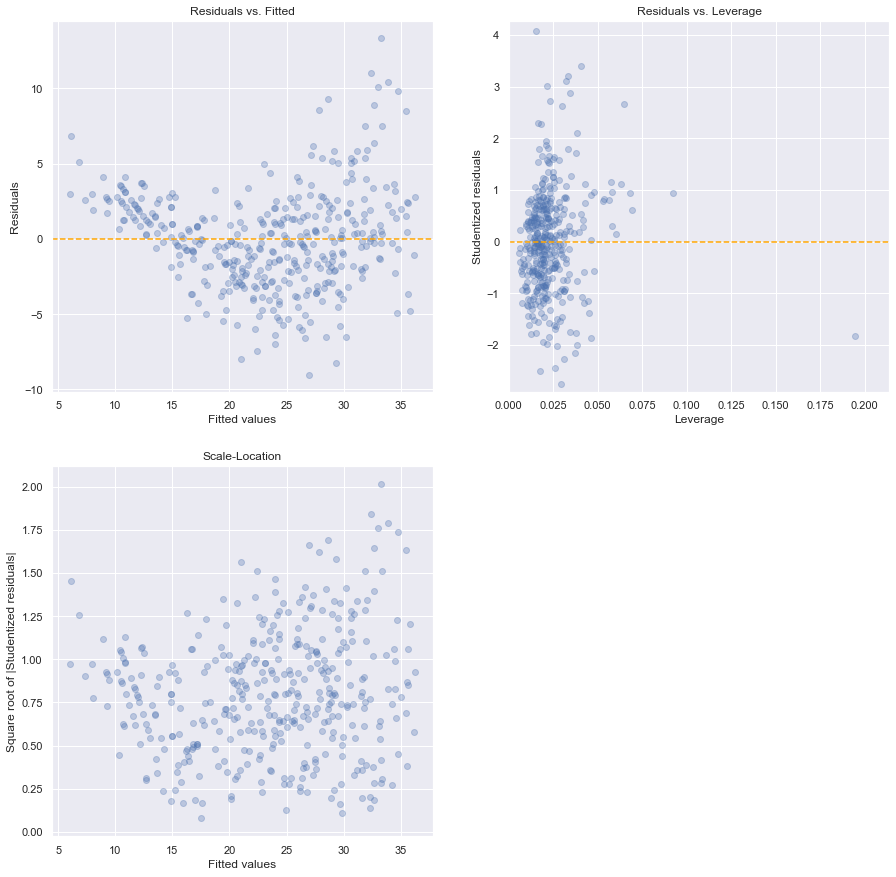

In [27]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand

# Compute residuals
predicted_mpg = reg_all.predict(X)
residuals = (y - predicted_mpg).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Plot for residuals vs. fitted value
axes[0, 0].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 0].scatter(predicted_mpg, residuals, alpha = 0.3)
axes[0, 0].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predicted_mpg, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

# Hide the fourth unused subplot
axes[1, 1].axis("off")

Looking at the Residuals vs. Fitted plot, there appears to be moderate U-shape, which indicates that there might be non-linearity in the data. In addition, when looking at the Residuals vs. Leverage plot we can observe a few things. First, there are a number of observations with standardized residual values with absolute value greater than or equal to 3. Those are likely outliers. This is confirmed by looking at the Scale-Location plot, which has $\sqrt{|\text{Standardized residual}|}$ as the $y$-axis. Points with $\sqrt{|\text{Standardized residual}|} \geq 1.732$ have $| \text{Standardized residual} | \geq 3$, which again means that they are likely outliers. Going back the the Residuals vs. Leverage plot, we also see that there are a couple points with unusually high leverage. Again remember that after dropping the rows with null values, there are 392 observations in the data set, giving an average leverage value of $9/392 \approx 0.023$. There is one point with a leverage value of about 0.10, which is almost 5 times greater than the average. There is another point with a leverage of about 0.20, which is almost 10 times greater than the average.

## Part 5

**Fit some linear regression models with interaction effects. Do any interactions appear to be statistically significant?**

First, I will fit a linear regression model using all possible second order interaction effects.

In [28]:
X

,originEuropean,originJapanese,cylinders,displacement,horsepower,weight,acceleration,year
0,0.0,0.0,8,307.0,130.0,3504,12.0,70
1,0.0,0.0,8,350.0,165.0,3693,11.5,70
2,0.0,0.0,8,318.0,150.0,3436,11.0,70
3,0.0,0.0,8,304.0,150.0,3433,12.0,70
4,0.0,0.0,8,302.0,140.0,3449,10.5,70
...,...,...,...,...,...,...,...,...
387,0.0,0.0,4,140.0,86.0,2790,15.6,82
388,1.0,0.0,4,97.0,52.0,2130,24.6,82
389,0.0,0.0,4,135.0,84.0,2295,11.6,82
390,0.0,0.0,4,120.0,79.0,2625,18.6,82


In [29]:
# Using ExtendedLinearRegression
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
# Need to delete the column 8 of interactions, since that is the interaction
# between originEuropean and originJapanese, which originated from the single predictor origin
all_interactions = np.delete(poly.fit_transform(X), 8, axis = 1)
reg_all_interactions = ExtendedLinearRegression()
stats_all_interactions = reg_all_interactions.detailed_linear_regression(all_interactions, y)

In [30]:
np.round(stats_all_interactions["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,44.0119,51.4674,0.8551,0.3930
1,-35.1651,12.6020,-2.7904,0.0055
2,-37.6464,14.2613,-2.6398,0.0086
3,3.3016,8.1865,0.4033,0.6870
4,-0.3529,0.1974,-1.7879,0.0746
5,0.5312,0.3390,1.5671,0.1179
6,-0.0033,0.0182,-0.1791,0.8580
7,-6.0483,2.1466,-2.8176,0.0051
8,0.4833,0.5923,0.8159,0.4151
9,-0.7210,1.0883,-0.6625,0.5081


In [31]:
np.round(stats_all_interactions["oa_stats"], 4)

Residual standard error     2.6284
R-squared                   0.8967
F-statistic                88.3373
F-test p-value              0.0000
dtype: float64

In [32]:
# Using R-style formulas in StatsModels
columns = "+".join(Auto.columns.drop(["mpg", "name"]))
formula = "mpg ~ (" + columns + ")**2"
mod_all_interactions = smf.ols(formula = formula, data = Auto)
res_all_interactions = mod_all_interactions.fit()
print(res_all_interactions.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     88.34
Date:                Wed, 18 Dec 2019   Prob (F-statistic):          1.74e-153
Time:                        16:10:16   Log-Likelihood:                -916.16
No. Observations:                 392   AIC:                             1904.
Df Residuals:                     356   BIC:                             2047.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

While we could perform backward selection by sequentially removing the interaction term with the highest p-value, re-calculating the least squares regression with the smaller set of predictors, and then continuing with the process until some sort of stopping condition is met (e.g. all p-values being under a given threshold or the adjusted $R^2$ value no longer increasing with the removal of predictors), I will not do so in the Python implementation of this exercise because it can get very tedious to show each step. I did do so when completing this exercise in R. Also, in Chapter 6 we will explore how to do automated forward and backward stepwise selection. Instead, I will go straight to the model I got after going through the process of backwards stepwise selection.

In [33]:
back_sel_ints = pd.DataFrame({"cylinders:acceleration": X["cylinders"]*X["acceleration"],
                             "cylinders:year": X["cylinders"]*X["year"],
                             "displacement:weight": X["displacement"]*X["weight"],
                             "displacement:year": X["displacement"]*X["year"], 
                             "displacement:originEuropean": X["displacement"]*X["originEuropean"],
                             "displacement:originJapanese": X["displacement"]*X["originJapanese"],
                             "horsepower:weight": X["horsepower"]*X["weight"],
                             "horsepower:acceleration": X["horsepower"]*X["acceleration"],
                             "horsepower:year": X["horsepower"]*X["year"],
                             "weight:originEuropean": X["weight"]*X["originEuropean"],
                             "weight:originJapanese": X["weight"]*X["originJapanese"],
                             "acceleration:year": X["acceleration"]*X["year"],
                             "acceleration:originEuropean": X["acceleration"]*X["originEuropean"],
                             "acceleration:originJapanese": X["acceleration"]*X["originJapanese"],
                             "year:originEuropean": X["year"]*X["originEuropean"],
                             "year:originJapanese": X["year"]*X["originJapanese"]})
back_sel_X = X.join(back_sel_ints)
back_sel_reg = ExtendedLinearRegression()
back_sel_stats = back_sel_reg.detailed_linear_regression(back_sel_X, y)

In [34]:
back_sel_stats["param_stats"].set_index(back_sel_X.columns.insert(0, "intercept"))

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,28.241186,43.440239,0.650116,5.159992e-01
originEuropean,-37.807843,10.246032,-3.689999,2.560475e-04
originJapanese,-33.898107,11.388121,-2.976620,3.095694e-03
cylinders,6.103029,6.179088,0.987691,3.239148e-01
displacement,-0.382888,0.131822,-2.904595,3.886077e-03
horsepower,0.657029,0.253393,2.592925,9.873358e-03
weight,-0.008357,0.001400,-5.970502,5.313329e-09
acceleration,-4.969915,1.786815,-2.781438,5.673826e-03
year,0.579367,0.529995,1.093156,2.749985e-01
cylinders:acceleration,0.232564,0.069485,3.346970,8.961755e-04


In [35]:
np.round(back_sel_stats["oa_stats"], 4)

Residual standard error      2.6055
R-squared                    0.8954
F-statistic                130.9020
F-test p-value               0.0000
dtype: float64

In [36]:
# Using R-style formulas in StatsModels
mod_backwards_sel = smf.ols(formula = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + \
                            year + origin + cylinders:acceleration + cylinders:year + displacement:weight + \
                            displacement:year + displacement:origin + horsepower:weight + \
                            horsepower:acceleration + horsepower:year + weight:origin + acceleration:year + \
                            acceleration:origin + year:origin", data = Auto)
res_backwards_sel = mod_backwards_sel.fit()
print(res_backwards_sel.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     130.9
Date:                Wed, 18 Dec 2019   Prob (F-statistic):          1.02e-163
Time:                        16:10:16   Log-Likelihood:                -918.70
No. Observations:                 392   AIC:                             1887.
Df Residuals:                     367   BIC:                             1987.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In total, using backward selection allowed us to increase our adjusted $R^2$ by 0.002 from the original value of 0.8866, which is a rather small increase. More importantly dropping unnecessary interaction terms helped a lot in simplifying the model to make it easier to interpret. Exploring a little bit, it seems as if removing further interaction terms doesn't improve the adjusted $R^2$ value. What we are left with are the following interactions, grouped by level of statistical significance. 

- p-value less than 0.001: `cylinders:acceleration`, `displacement:originJapanese`, `acceleration:originEuropean`, `acceleration:originJapanese`
- p-value between 0.001 and 0.01: `weight:originJapanese`
- p-value between 0.01 and 0.05: `displacement:year`, `horsepower:year`, `acceleration:year`, `year:originEuropean`, `year:originJapanese`
- p-value between 0.05 and 0.1: `horsepower:acceleration`
- p-value greater than 0.1: `cylinders:year`, `displacement:originEuropean`, `horsepower:weight`, `weight:originEuropean`

An alternative, and generally better, approach to picking interaction terms to potentially include is to use our domain knowledge to think about which of the predictors might be related to each other. For example, it is reasonable to hypothesize that there might be an interaction effect between the number of engine cylinders and engine displacement, since spreading out the displacement among more cylinders might influence fuel economy.

In [37]:
# Using R-style formulas in StatsModels
mod_backwards_sel = smf.ols(formula = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + \
                            year + origin + cylinders:acceleration + cylinders:year + displacement:weight + \
                            displacement:year + displacement:origin + horsepower:weight + \
                            horsepower:acceleration + horsepower:year + weight:origin + acceleration:year + \
                            acceleration:origin + year:origin", data = Auto)
res_backwards_sel = mod_backwards_sel.fit()
print(res_backwards_sel.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     130.9
Date:                Wed, 18 Dec 2019   Prob (F-statistic):          1.02e-163
Time:                        16:10:17   Log-Likelihood:                -918.70
No. Observations:                 392   AIC:                             1887.
Df Residuals:                     367   BIC:                             1987.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [38]:
# Using R-style formulas in StatsModels
columns = "+".join(Auto.columns.drop(["mpg", "name"]))
formula = "mpg ~ " + columns + " + cylinders:displacement"
mod_cyl_dis = smf.ols(formula = formula, data = Auto)
res_cyl_dis = mod_cyl_dis.fit()
print(res_cyl_dis.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     235.4
Date:                Wed, 18 Dec 2019   Prob (F-statistic):          6.88e-150
Time:                        16:10:17   Log-Likelihood:                -992.95
No. Observations:                 392   AIC:                             2006.
Df Residuals:                     382   BIC:                             2046.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

In [39]:
cyl_dis_X = X.join(pd.DataFrame({"cylinders:displacement": X["cylinders"]*X["displacement"]}))
cyl_dis_reg = ExtendedLinearRegression()
cyl_dis_stats = back_sel_reg.detailed_linear_regression(cyl_dis_X, y)

In [40]:
cyl_dis_stats["param_stats"].set_index(cyl_dis_X.columns.insert(0, "intercept"))

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,-3.493584,4.763410,-0.733421,4.637413e-01
originEuropean,1.345447,0.555147,2.423589,1.582101e-02
originJapanese,1.458021,0.547722,2.661971,8.088902e-03
cylinders,-2.632836,0.411915,-6.391695,4.675786e-10
displacement,-0.072670,0.014603,-4.976240,9.734692e-07
horsepower,-0.047378,0.013362,-3.545774,4.389032e-04
weight,-0.005390,0.000636,-8.476780,4.440892e-16
acceleration,0.059625,0.091716,0.650110,5.160031e-01
year,0.772657,0.048340,15.983763,0.000000e+00
cylinders:displacement,0.013228,0.001743,7.588165,2.398082e-13


In [41]:
np.round(cyl_dis_stats["oa_stats"], 4)

Residual standard error      3.0864
R-squared                    0.8472
F-statistic                235.3832
F-test p-value               0.0000
dtype: float64

In this expanded model, the `cylinders:displacement` term has a p-value of essentially zero, which provides evidence to suggest that it is a statistically significant interaction. Moreover, its inclusion has resulted in the adjusted $R^2$ value to increase from 0.8205 in the original model using all predictors to 0.8436.

## Part 6
**Try a few different transformations of the variables, such as $\log(X), \sqrt{X}, X^2$. Comment on your findings.**

To get a sense of which transformations I want to try out for each quantitative variable, focusing on `displacement`, `horsepower`, `weight`, and `acceleration`, I'll look at the scatterplots of each one versus `mpg`.

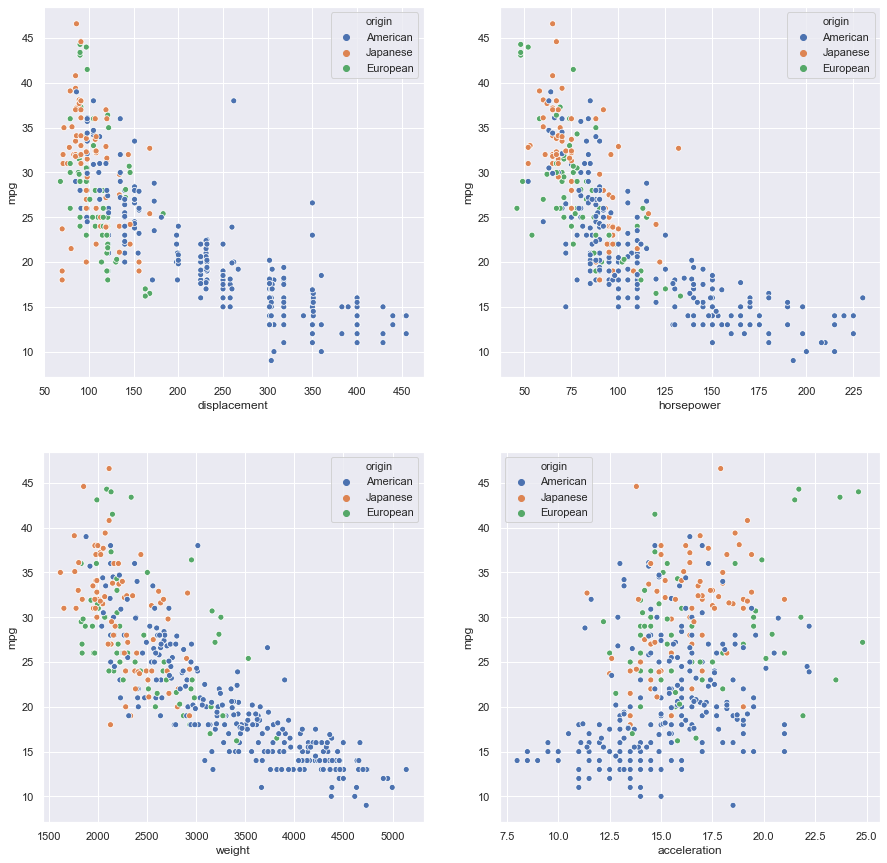

In [42]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
sns.scatterplot(x = "displacement", y = "mpg", hue = "origin", data = Auto, ax = axes[0, 0])
sns.scatterplot(x = "horsepower", y = "mpg", hue = "origin", data = Auto, ax = axes[0, 1])
sns.scatterplot(x = "weight", y = "mpg", hue = "origin", data = Auto, ax = axes[1, 0])
sns.scatterplot(x = "acceleration", y = "mpg", hue = "origin", data = Auto, ax = axes[1, 1])

The book already explored nonlinear transformations of `horsepower` to predict `mpg`, so I will first look at transforms of `acceleration`.

In [43]:
# Using StatsModels
mod = sm.OLS(Auto["mpg"], sm.add_constant(Auto["acceleration"]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     85.15
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.78e-18
Time:                        16:10:19   Log-Likelihood:                -1322.5
No. Observations:                 392   AIC:                             2649.
Df Residuals:                     390   BIC:                             2657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8332      2.048      2.359   

C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [44]:
# Using ExtendedLinearRegression
X = Auto["acceleration"].values.reshape(-1, 1)
y = Auto["mpg"].values.reshape(-1, 1)
reg = ExtendedLinearRegression()
reg_stats = reg.detailed_linear_regression(X, y)

In [45]:
reg_stats["param_stats"]

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,4.833250,2.048500,2.359409,0.018795
1,1.197624,0.129786,9.227691,0.000000


In [46]:
reg_stats["oa_stats"]

Residual standard error    7.080211e+00
R-squared                  1.792071e-01
F-statistic                8.515028e+01
F-test p-value             1.778576e-18
dtype: float64

[(-2.6751814542715557, 3.452606886709202),
 Text(0, 0.5, 'Studentized residuals'),
 (0, 0.0344910589880053),
 Text(0.5, 0, 'Leverage'),
 Text(0.5, 1.0, 'Residuals vs. Leverage')]

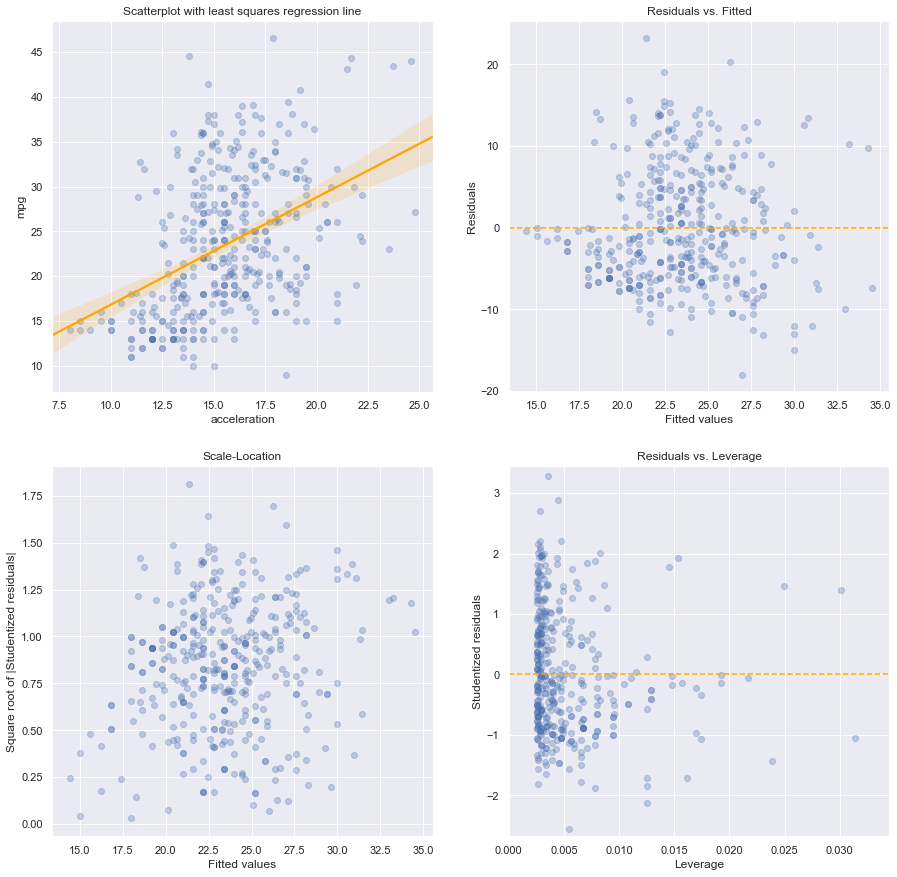

In [47]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand

# Compute residuals
predicted_mpg = reg.predict(X)
residuals = (y - predicted_mpg).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones(X.shape), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Scatterplot of data with least squares regression line
sns.regplot(x = "acceleration", y = "mpg", data = Auto, scatter_kws = {"alpha": 0.3}, line_kws = {"color": "orange"},
           ax = axes[0, 0])
axes[0, 0].set(title = "Scatterplot with least squares regression line")
# Plot for residuals vs. fitted value
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(predicted_mpg, residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predicted_mpg, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[1, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[1, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[1, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

It appears that there might be heteroscedasticity, or non-constant variances in the error terms, so let's first see how applying a logarithmic transportation affects the model.

In [48]:
# Using StatsModels
mod = sm.OLS(Auto["mpg"], sm.add_constant(np.log(Auto["acceleration"])))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     91.49
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.31e-19
Time:                        16:10:22   Log-Likelihood:                -1319.9
No. Observations:                 392   AIC:                             2644.
Df Residuals:                     390   BIC:                             2652.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -27.8343      5.373     -5.180   

C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [49]:
# Using ExtendedLinearRegression
X = np.log(Auto["acceleration"].values.reshape(-1, 1))
y = Auto["mpg"].values.reshape(-1, 1)
reg = ExtendedLinearRegression()
reg_stats = reg.detailed_linear_regression(X, y)

In [50]:
reg_stats["param_stats"]

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-27.834291,5.373054,-5.180349,3.554624e-07
1,18.801251,1.965653,9.564889,0.000000e+00


In [51]:
reg_stats["oa_stats"]

Residual standard error    7.033466e+00
R-squared                  1.900094e-01
F-statistic                9.148710e+01
F-test p-value             1.305363e-19
dtype: float64

[(-2.6979196683012128, 3.4524419385248555),
 Text(0, 0.5, 'Studentized residuals'),
 (0, 0.03888736383518781),
 Text(0.5, 0, 'Leverage'),
 Text(0.5, 1.0, 'Residuals vs. Leverage')]

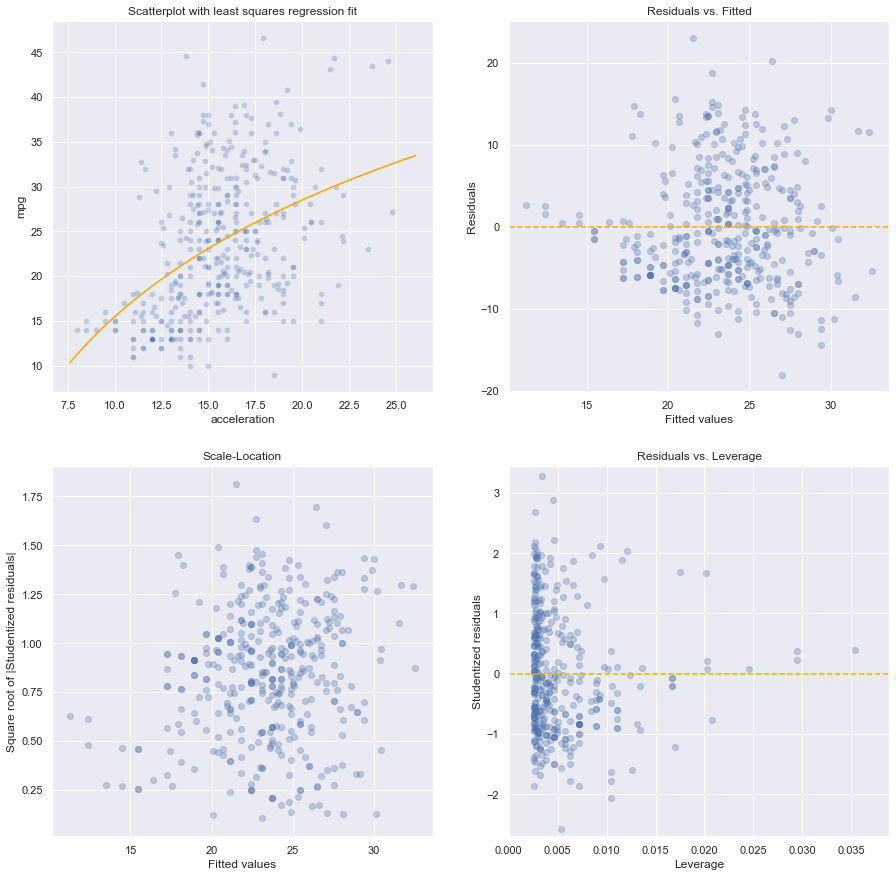

In [52]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand

# Compute residuals
predicted_mpg = reg.predict(X)
residuals = (y - predicted_mpg).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones(X.shape), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Scatterplot of data with least squares regression line
sns.scatterplot(x = "acceleration", y = "mpg", data = Auto, alpha = 0.3, ax = axes[0, 0])
x_vals = np.linspace(Auto["acceleration"].min()*0.95, Auto["acceleration"].max()*1.05, num = 100)
axes[0, 0].plot(x_vals, reg.predict(np.log(x_vals.reshape(-1, 1))), color = "orange")
axes[0, 0].set(title = "Scatterplot with least squares regression fit")
# Plot for residuals vs. fitted value
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(predicted_mpg, residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predicted_mpg, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[1, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[1, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[1, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

While the transformation did bump up the $R^2$ value very slightly, it didn't really do anything to help with the residuals. This is probably due to the fact that two cars with the same 0 to 60 mile per hour time could be quite different in other ways that would affect fuel economy, such has differences in engine efficiency. For the remainder of the problem, let's turn our attention the the relationship between engine displacement and fuel efficiency. From the scatterplot, it is pretty clear that there is a nonlinear relationship between the two quantities. Let's start off by comparing a linear model to one that also includes the quadratic term.

Note that when doing this problem in R, we used the `poly()` function, which produces [*orthogonal polynomials*](https://en.wikipedia.org/wiki/Orthogonal_polynomials), and not raw ones. This is important because even though orthogonalizing the polynomials doesn't affect overall predictions the model will give, it reduces the correlation between the various powers of $X$ at the cost of sacrificing coefficient interpretability. Reducing the correlation between the powers improves our ability to interpret the t-statistics for each coeffiecient, because it alleviates the issue of multicollinearity. Since the PolynomialFeatures transformer in scikit-learn generates raw polynomials, we add an extra the orthogonalization step in order to better evaluate whether or not the inclusion of non-linear terms improves the model fit.

In [53]:
# Using ExtendedLinearRegression
X = Auto["displacement"].values.reshape(-1, 1)
y = Auto["mpg"].values.reshape(-1, 1)
reg = ExtendedLinearRegression()
reg_stats = reg.detailed_linear_regression(X, y)

In [54]:
reg_stats["param_stats"]

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,35.120636,0.494428,71.032840,0.0
1,-0.060051,0.002240,-26.808153,0.0


In [55]:
reg_stats["oa_stats"]

Residual standard error    4.635101e+00
R-squared                  6.482294e-01
F-statistic                7.186771e+02
F-test p-value             1.660642e-90
dtype: float64

In [56]:
poly = PolynomialFeatures(degree = 2, include_bias = True)
X = poly.fit_transform(Auto["displacement"].values.reshape(-1, 1))
y = Auto["mpg"].values.reshape(-1, 1)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(X)[0][:, 1:]
reg = ExtendedLinearRegression(fit_intercept = True)
reg_stats = reg.detailed_linear_regression(ortho_X, y)

In [57]:
reg_stats["param_stats"]

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,23.445918,0.220474,106.343189,0.000000e+00
1,124.258488,4.365164,28.465936,0.000000e+00
2,31.089530,4.365164,7.122190,5.135892e-12


In [58]:
reg_stats["oa_stats"]

Residual standard error    4.365164e+00
R-squared                  6.888087e-01
F-statistic                4.305175e+02
F-test p-value             2.476449e-99
dtype: float64

As we can see, the quadratic term has a p-value of essentially zero, which is quite statistically significant. Moreover, the inclusion of the quadratic term improves the $R^2$ value from 0.6482 in the linear model to 0.6888. This strongly suggests that the model which includes the quadtratic term is a better fit than the model which does not include it. To finish, lets now compare the quadratic model to a quintic one.

In [59]:
poly = PolynomialFeatures(degree = 5, include_bias = True)
X = poly.fit_transform(Auto["displacement"].values.reshape(-1, 1))
y = Auto["mpg"].values.reshape(-1, 1)
# Orthogonalize the powers of the predictor using QR decomposition
ortho_X = np.linalg.qr(X)[0][:, 1:]
reg = ExtendedLinearRegression(fit_intercept = True)
reg_stats = reg.detailed_linear_regression(ortho_X, y)

In [60]:
reg_stats["param_stats"]

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,23.445918,0.220860,106.157604,0.000000e+00
1,124.258488,4.372796,28.416258,0.000000e+00
2,31.089530,4.372796,7.109761,5.562661e-12
3,-4.465506,4.372796,-1.021202,3.077903e-01
4,-0.774712,4.372796,-0.177166,8.594694e-01
5,3.299119,4.372796,0.754465,4.510244e-01


In [61]:
reg_stats["oa_stats"]

Residual standard error    4.372796e+00
R-squared                  6.901281e-01
F-statistic                1.719352e+02
F-test p-value             7.361722e-96
dtype: float64

First, we notice that none of the terms above order 2 (i.e. the cubic, quartic, and quintic terms) have statistically significant p-values. In addition, the adjusted $R^2$ value has dropped slightly from 0.6872 in the quadratic model to 0.6861. These two pieces of evidence suggest that including terms beyond order 2 does not improve the model.

# Applied Exercise 3

**This question should be answered using the `Carseats` data set.**

In [62]:
# Load the Carseats data set
# Use the unnamed zeroth column as the index
carseats_filepath = "Carseats.csv"
carseats = pd.read_csv(carseats_filepath, index_col = ["Unnamed: 0"])
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [63]:
# Encode categorical predictors using OneHotEncoder
# Set the categories and drop the first category when encoding to use reduced-rank coding
# This then replicates the default behavior of how Patsy and R do categorical encoding
enc = OneHotEncoder(categories = [["Bad", "Medium", "Good"], ["No", "Yes"], ["No", "Yes"]], drop = "first")
cat_pred = enc.fit_transform(carseats.loc[:, ["ShelveLoc", "Urban", "US"]]).toarray()
cat_pred = pd.DataFrame(cat_pred, columns = ["ShelveLocMedium", "ShelveLocGood", "UrbanYes", "USYes"])
quant_pred = carseats.loc[:, ["CompPrice", "Income", "Advertising", "Population", "Price", "Age", "Education"]].reset_index(drop = True)
carseats_encoded = cat_pred.join([quant_pred])

## Part 1
**Fit a multiple regression model to predict `Sales` using `Price`, `Urban`, and `US`.**

In [64]:
# Using R-style formulas in StatsModels
mod_1 = smf.ols(formula = "Sales ~ Price + Urban + US", data = carseats)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.39e-23
Time:                        16:10:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036   

In [65]:
# Using ExtendedLinearRegression
X_1 = carseats_encoded.loc[:, ["UrbanYes", "USYes", "Price"]]
y = carseats["Sales"].values.reshape(-1, 1)
reg_1 = ExtendedLinearRegression()
reg_1_stats = reg_1.detailed_linear_regression(X_1, y)

In [66]:
reg_1_stats["param_stats"].set_index(X_1.columns.insert(0, "intercept"))

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,13.043469,0.651012,20.035674,0.000000
UrbanYes,-0.021916,0.271650,-0.080678,0.935739
USYes,1.200573,0.259042,4.634673,0.000005
Price,-0.054459,0.005242,-10.389232,0.000000


In [67]:
reg_1_stats["oa_stats"]

Residual standard error    2.472492e+00
R-squared                  2.392754e-01
F-statistic                4.151877e+01
F-test p-value             2.385199e-23
dtype: float64

## Part 2
**Provide an interpretation of each coefficient in the model. Be careful -- some of the variables in the model are qualitative!**

The coefficient of -0.054459 for `Price` means that, for a given location (i.e. fixed values of `Urban` and `US`), increasing the price of a car seat by \\$1 results in a decrease of sales by approximately 54.46 units, on average, in the model. The coefficient of -0.021916 for `UrbanYes` means that, for a given carseat price point and value of `US`, the model predicts urban areas to have approximately 22 fewer carseat sales on average compared to non-urban areas. The coefficient of 1.200573 for `USYes` means that, for a given carseat price point and value of `Urban`, the model predicts that stores in the United States have 1201 more carseat sales on average than stores outside the United States.

## Part 3
**Write out the model in equation form, being careful to handle the qualitative variables properly.**

The model has the following equation.

\begin{equation}
    \hat{Y} = 13.043 - 0.054X_1 - 0.022X_2 + 1.200X_3
\end{equation}

Here, $\hat{y}$ is the estimated carseat sales, in thousands of car seats; $x_{1j}$ is the price of the carseat at the jth store, in dollars; and $x_{2j}$ and $x_{3j}$ are dummy variables to represent whether or not the $j$th store at is located in an urban area and in the United States, respectively. More concretely, $x_{2j}$ and $x_{3j}$ use the following coding scheme.

\begin{align}
    x_{2j} &= 
    \begin{cases}
        1, & \text{if the $j$th store is in an urban location} \\
        0, & \text{if the $j$th store is not in an urban location}
    \end{cases}\\
    x_{3j} &= 
    \begin{cases}
        1, & \text{if the $j$th store is in the United States} \\
        0, & \text{if the $j$th store is not in the United States}
    \end{cases}
\end{align}

## Part 4
**For which of the predictors can you reject the null hypothesis $H_0 : \beta_j = 0$?**

The p-values for the intercept, `Price`, and `USYes` are all essentially zero, which provides strong evidence to reject the null hypothesis $H_0: \beta_j = 0$ for those predictors. The p-value for `UrbanYes`, however, is 0.936, so there is no evidence to reject the null hypothesis that it has a non-zero coefficient in the true relationship between the predictors and `Sales`.

## Part 5
**On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.**

In [68]:
# Using R-style formulas in StatsModels
mod_2 = smf.ols(formula = "Sales ~ Price + US", data = carseats)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.66e-24
Time:                        16:10:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

In [69]:
# Using ExtendedLinearRegression
X_2 = carseats_encoded.loc[:, ["USYes", "Price"]]
y = carseats["Sales"].values.reshape(-1, 1)
reg_2 = ExtendedLinearRegression()
reg_2_stats = reg_2.detailed_linear_regression(X_2, y)

In [70]:
reg_2_stats["param_stats"].set_index(X_2.columns.insert(0, "intercept"))

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,13.030793,0.630976,20.651794,0.000000
USYes,1.199643,0.258461,4.641485,0.000005
Price,-0.054478,0.005230,-10.416123,0.000000


In [71]:
reg_2_stats["oa_stats"]

Residual standard error    2.469397e+00
R-squared                  2.392629e-01
F-statistic                6.243114e+01
F-test p-value             2.661146e-24
dtype: float64

## Part 6
**How well do the models in Part 1 and Part 5 fit the data?**

Text(0.5, 0.98, 'Diagnostic plots for regression from Part 1')

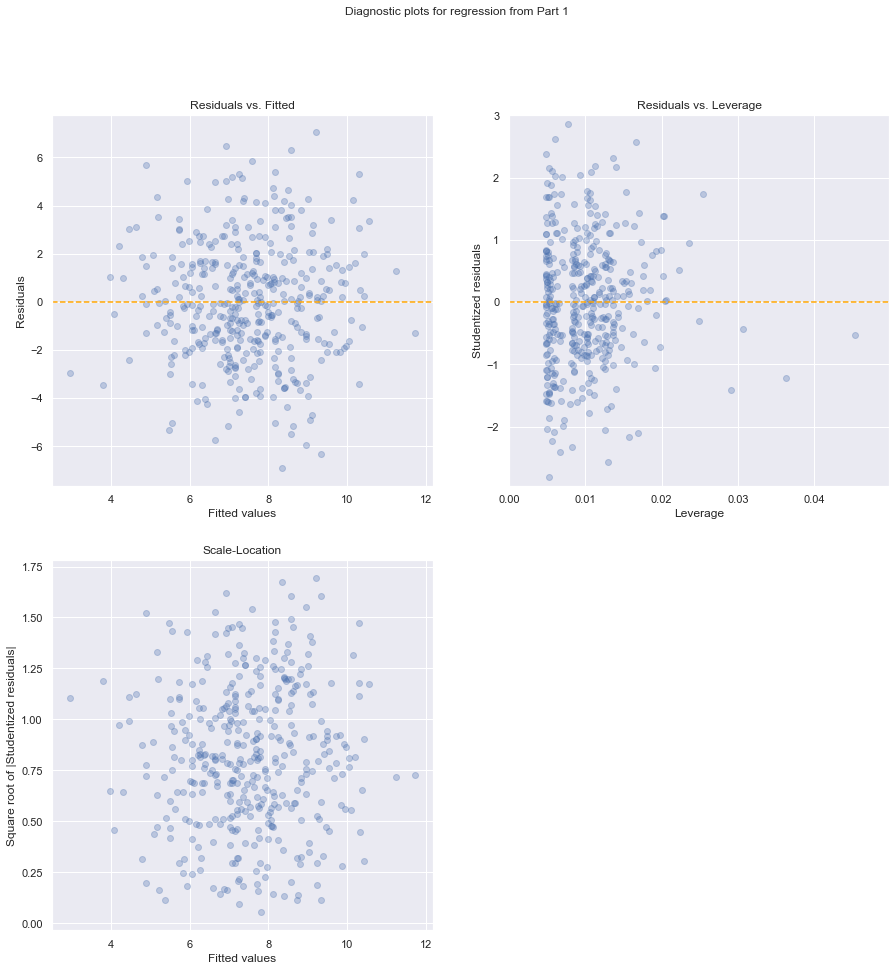

In [72]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand
# Start with model for Part 1
X = X_1
# Compute residuals
predictions = reg_1.predict(X)
residuals = (y - predictions).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Plot for residuals vs. fitted value
axes[0, 0].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 0].scatter(predictions, residuals, alpha = 0.3)
axes[0, 0].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predictions, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

# Hide the fourth unused subplot
axes[1, 1].axis("off")

fig.suptitle("Diagnostic plots for regression from Part 1")

Text(0.5, 0.98, 'Diagnostic plots for regression from Part 5')

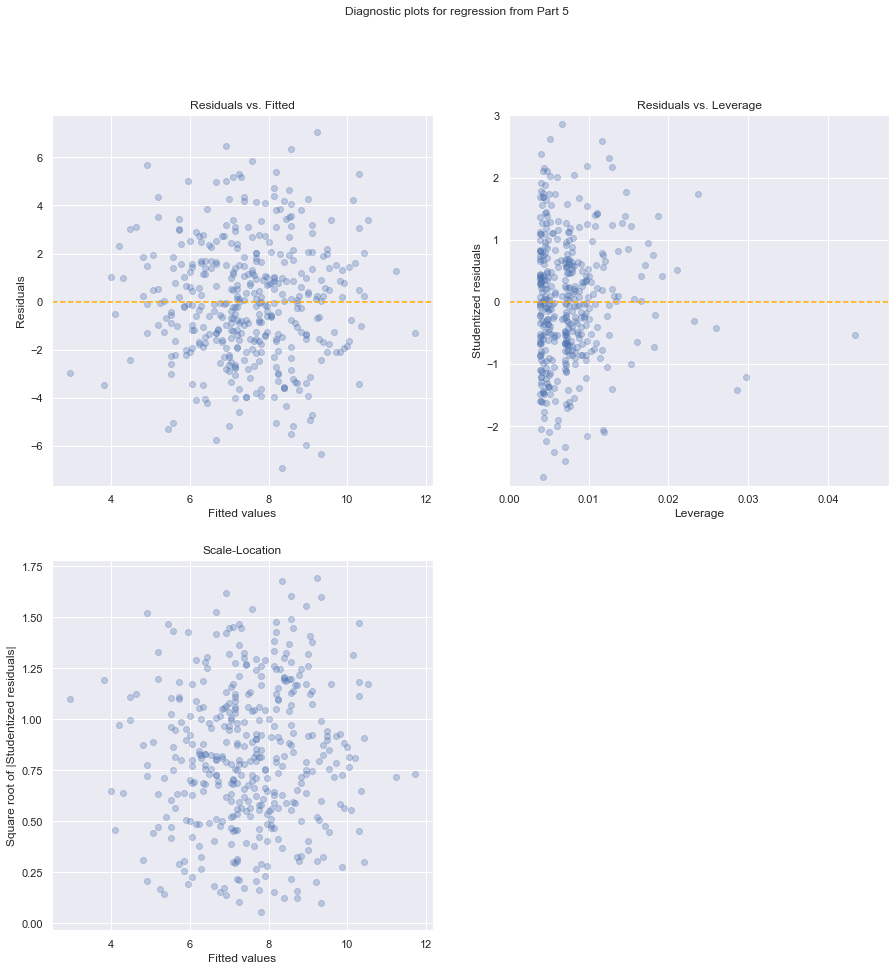

In [73]:
# Producing Residuals vs. Fitted, Scale-Location, and Residuals vs. Leverage plots by hand
# Start with model for Part 5
X = X_2
# Compute residuals
predictions = reg_2.predict(X)
residuals = (y - predictions).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Plot for residuals vs. fitted value
axes[0, 0].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 0].scatter(predictions, residuals, alpha = 0.3)
axes[0, 0].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predictions, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

# Hide the fourth unused subplot
axes[1, 1].axis("off")

fig.suptitle("Diagnostic plots for regression from Part 5")

The models in Part 1 and Part 5 both fit the data about equally well, with identical $R^2$ values of 0.2393. In addition, when comparing the diagnostic plots between the two models, there isn't any discernable visual differences that would strongly indicate that one model is a better fit than the other.

## Part 7
**Using the model from Part 5, obtain 95% confidence intervals for the coefficient(s).**

In [74]:
reg_2.param_conf_int().set_index(X_2.columns.insert(0, "intercept"))

,2.5%,97.5%
intercept,11.79032,14.271265
USYes,0.69152,1.707766
Price,-0.06476,-0.044195


## Part 8
**Is there evidence of outliers or high leverage observations in the model from Part 5?**

When we look at the residuals vs. leverage plot for the model from Part 5 that I generated in Part 6, we see that there are a number of observations with standardized residuals close to 3 in absolute value. Those observations are possible outliers. We can also see in the same plot that there are number of high leverage points with leverage values greatly exceeding the average leverage of $3/400 = 0.0075$, though those high leverage observations are not likely outliers, as they have studentized residual values with absolute value less than 2.

# Applied Exercise 4
**In this problem we will investigate the t-statistic for the null hypothesis $H_0: \beta = 0$ in simple linear regression without an intercept. To begin, we generate a predictor `x` and a response `y` as follows.**

```
> np.random.seed(1)
> x = np.random.normal(loc = 0.0, scale = 1.0, size = 100)
> y = 2*x + np.random.normal(loc = 0.0, scale = 1.0, size = 100)
```

In [75]:
np.random.seed(1)
x = np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))
y = 2*x + np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))

## Part 1
**Perform a simple linear regresion of `y` onto `x` *without* an intercept. Report the coefficient estimate $\hat{\beta}$, the standard error of this coefficient estimate, and the t-statistic and p-value associated with the null hypothesis $H_0: \beta = 0$. Comment on these results. (You can perform regression without an intercept by not adding a column of constants to `x` when using StatsModels, or by using the parameter `fit_intercept = False` in scikit-learn. Note that when you don't include an intercept in StatsModels, it will automatically adjust some of the computations, such as using the uncentered total sum of squares in computing the values for $R^2$ and the F-statistic.**

In [76]:
# Using StatsModels
mod_y_onto_x = sm.OLS(y, x)
res_y_onto_x = mod_y_onto_x.fit()
print(res_y_onto_x.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                    3.46e-36
Time:                        16:10:29   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [77]:
# Centered R-squared value
1 - (res_y_onto_x.ssr/res_y_onto_x.centered_tss)

0.794733747203295

In [78]:
# Centered F-statistic
(res_y_onto_x.centered_tss - res_y_onto_x.ssr)/(res_y_onto_x.ssr/99)

383.3004203133638

In [79]:
# Using ExtendedLinearRegression Class
reg_y_onto_x = ExtendedLinearRegression(fit_intercept = False)
y_onto_x_stats = reg_y_onto_x.detailed_linear_regression(x, y)

In [80]:
np.round(y_onto_x_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.1067,0.1064,19.7918,0.0


In [81]:
np.round(y_onto_x_stats["oa_stats"], 4)

Residual standard error      0.9444
R-squared                    0.7947
F-statistic                383.3004
F-test p-value               0.0000
dtype: float64

[(-2.416615631724297, 2.2948541768598196)]

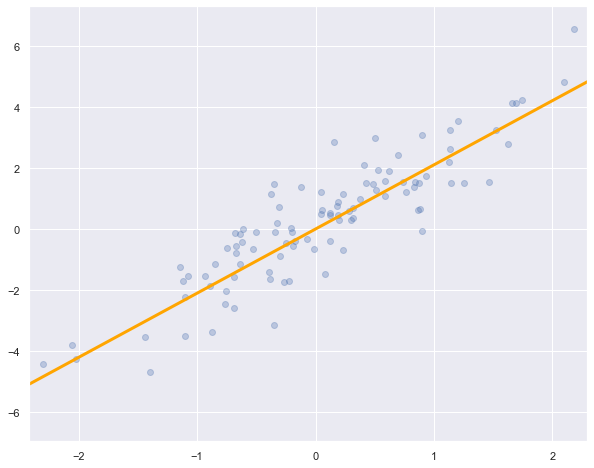

In [82]:
# Plotting by hand using scikit-learn

X = np.linspace(-3, 3, num = 100).reshape(-1, 1)
predictions = reg_y_onto_x.predict(X)
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()

# Plot the regression line in orange with a line width of 3 to increase visibility
ax.plot(X, predictions, color = "orange", linewidth = 3)

# Plot the scatterplot with an alpha value of 0.3 for the markers to reduce clutter
ax.scatter(x, y, alpha = 0.3)

ax.set(xlim = (x.min()*1.05, x.max()*1.05))

When performing a simple linear regression of `y` onto `x` without an intercept, we have $\hat{\beta} = 2.1067$ with a standard error of 0.1064 and p-value of essentially zero associated with the null hypothesis $H_0: \beta = 0$. This is reasonable and expected given the fact that the true relationship between `y` and `x` is given by $Y = 2X + \epsilon$. In addition, an $R^2$ value of 0.7947 indicates that about 79% of the variance in the data can be explained by the regression model.

## Part 2
**Now perform a simple linear regression of `x` onto `y` without an intercept, and report on the coefficient estimate, its standard error, and the corresponding t-statistic and p-values associated with the null hypothesis $H_0 : \beta = 0$. Comment on these results.**

In [83]:
# Using StatsModels
mod_x_onto_y = sm.OLS(x, y)
res_x_onto_y = mod_x_onto_y.fit()
print(res_x_onto_y.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                    3.46e-36
Time:                        16:10:30   Log-Likelihood:                         -49.891
No. Observations:                 100   AIC:                                      101.8
Df Residuals:                      99   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [84]:
# Centered R-squared value
1 - (res_x_onto_y.ssr/res_x_onto_y.centered_tss)

0.797308671494011

In [85]:
# Centered F-statistic
(res_x_onto_y.centered_tss - res_x_onto_y.ssr)/(res_x_onto_y.ssr/99)

389.42740698240976

In [86]:
# Using ExtendedLinearRegression Class
reg_x_onto_y = ExtendedLinearRegression(fit_intercept = False)
x_onto_y_stats = reg_x_onto_y.detailed_linear_regression(y, x)

In [87]:
np.round(x_onto_y_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,0.3789,0.0191,19.7918,0.0


In [88]:
np.round(x_onto_y_stats["oa_stats"], 4)

Residual standard error      0.4005
R-squared                    0.7973
F-statistic                389.4274
F-test p-value               0.0000
dtype: float64

[(-4.923821273560737, 6.88994306913786)]

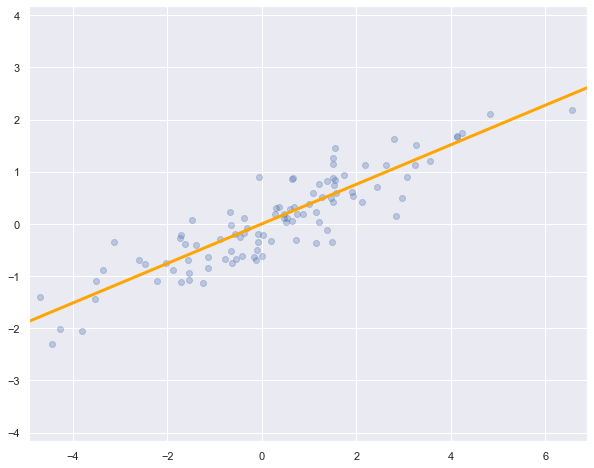

In [89]:
# Plotting by hand using scikit-learn

X = np.linspace(-10, 10, num = 100).reshape(-1, 1)
predictions = reg_x_onto_y.predict(X)
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()

# Plot the regression line in orange with a line width of 3 to increase visibility
ax.plot(X, predictions, color = "orange", linewidth = 3)

# Plot the scatterplot with an alpha value of 0.3 for the markers to reduce clutter
ax.scatter(y, x, alpha = 0.3)

ax.set(xlim = (y.min()*1.05, y.max()*1.05))

When performing a simple linear regression of `x` onto `y` without an intercept, we have $\hat{\beta} = 0.3789$ with a standard error of 0.0191 and p-value of essentially zero associated with the null hypothesis $H_0: \beta = 0$. This is also reasonable, if slightly shallower slope compared to what I expected, given the fact that the true relationship between `y` and `x` is given by $Y = 2X + \epsilon$. In other words, after solving for $x$ we get $X = \frac{1}{2}(Y - \epsilon) = \frac{1}{2}Y + \epsilon$ after absorbing the $1/2$ into a relabeled error term. After graphing the regression line on the scatterplot with y on the horizontal axis and x on the vertical axis, the slope does look reasonable. In addition, an $R^2$ value of 0.7973 indicates that about 80% of the variance in the data can be explained by the regression model.

## Part 3
**What is the relationship between the results obtained in Part 1 and Part 2?**

In Part 1, simple linear regression without an intercept gave a regression line of $\hat{y} = 2.1067x$. In Part 2, simple linear regression without an intercept gave a regression line of $\hat{x} = 0.3789y$. Both regression models have the same t-statistic for $\beta$, 19.792, as well as the same (uncentered) $R^2$ and F-statistic values (0.798 and 391.7, respectively), though the centered values differ slightly. Also, as discussed above, there is the true relationship $Y = 2X + \epsilon$ for the regression in Part 1, which can be rearranged to get the true relationship $X = \frac{1}{2}(Y - \epsilon)$ in Part 2.

## Part 4
**For the regression of $Y$ onto $X$ without an intercept, the t-statistic for $H_0 : \beta = 0$ takes the form $\hat{\beta}/\text{SE}(\hat{\beta})$, where $\hat{\beta}$ and $\text{SE}(\hat{\beta})$ are given by the following formulas.**

\begin{equation}
    \hat{\beta} = \frac{\sum_{j = 1}^n x_jy_j}{\sum_{j = i}^n x_j^2}
    \quad
    \text{SE}(\hat{\beta}) = \sqrt{\frac{\sum_{j = 1}^n \left( y_j - x_j\hat{\beta} \right)^2}{(n - 1)\sum_{j = 1}^n x_j^2}}
\end{equation}

**(These formulas are slightly different from those given in Sections 3.1.1 and 3.1.2, since here we are performing regression without an intercept.) Show algebraically, and confirm numerically in `R`, that the t-statistic can be written as**

\begin{equation}
    t = \frac{\left( \sqrt{n-1} \right) \sum_{j = 1}^n x_jy_j}
    {\sqrt{\left( \sum_{j = 1}^n x_j^2 \right) \left( \sum_{j = 1}^n y_j^2 \right) - \left( \sum_{j = 1}^n x_jy_j \right)^2}}.
\end{equation}

First, we note that

\begin{equation}
    \frac{1}{\text{SE}(\hat{\beta})} = 
    \sqrt{\frac{(n - 1)\sum_{j = 1}^n x_j^2}{\sum_{i = 1}^n \left( y_i - x_i\hat{\beta} \right)^2}} =
    \frac{\sqrt{(n - 1)} \sqrt{\sum_{j = 1}^n x_j^2}}{\sqrt{\sum_{i = 1}^n \left( y_i - x_i\hat{\beta} \right)^2}}.
\end{equation}

Thus, when we combine with $\hat{\beta}$ to compute the t-statistic, we get

\begin{equation}
    t = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})} = 
    \frac{\sqrt{\sum_{j = 1}^n x_j^2} \sqrt{(n - 1)} \left( \sum_{j = 1}^n x_jy_j \right)}
    {\left( \sum_{j = 1}^n x_j^2 \right) \sqrt{\sum_{j = 1}^n \left( y_j - x_j\hat{\beta} \right)^2}}.
\end{equation}

Note that we can do some cancelling with the $\sum_{j = 1}^n x_j^2$ that shows up in both the numerator and the denominator.

\begin{equation}
    t = \frac{\sqrt{(n - 1)} \sum_{j = 1}^n x_jy_j}
    {\sqrt{\sum_{j = 1}^n x_j^2} \sqrt{\sum_{j = 1}^n \left( y_j - x_j\hat{\beta} \right)^2}}
\end{equation}

Next, we can combine the two square roots in the denominator and focus there. To start off, we we note that

\begin{equation}
    \sum_{j = 1}^n \left( y_j - x_j\hat{\beta} \right)^2 = 
    \sum_{j = 1}^n \left( y_j^2 - 2x_jy_j\hat{\beta} + x_j^2\hat{\beta}^2 \right) = 
    \sum_{j = 1}^n y_j^2 - 2\hat{\beta}\sum_{j = 1}^n x_jy_j + \hat{\beta}^2\sum_{j = 1}^n x_j^2.
\end{equation}

Plugging in the formula for $\hat{\beta}$, this then becomes

\begin{equation}
    \sum_{j = 1}^n y_j^2 - 2\frac{\left( \sum_{j = 1}^n x_jy_j \right)^2}{\sum_{j = 1}^n x_j^2}
    + \frac{\left( \sum_{j = 1}^n x_jy_j \right)^2}{\sum_{j = 1}^n x_j^2} = 
    \sum_{j = 1}^n y_j^2 - \frac{\left( \sum_{j = 1}^n x_jy_j \right)^2}{\sum_{j = 1}^n x_j^2}.
\end{equation}

Multiplying this by $\sum_{j = 1}^n x_j^2$ gives us

\begin{equation}
    \left( \sum_{j = 1}^n x_j^2 \right) \left( \sum_{j = 1}^n y_j^2 \right) - \left( \sum_{j = 1}^n x_jy_j \right)^2.
\end{equation}

This completes the simplification of the denominator, giving us the desired formula for the t-statistic for $H_0: \beta = 0$.

\begin{equation}
    t = \frac{\left( \sqrt{n-1} \right) \sum_{j = 1}^n x_jy_j}
    {\sqrt{\left( \sum_{j = 1}^n x_j^2 \right) \left( \sum_{j = 1}^n y_j^2 \right) - \left( \sum_{j = 1}^n x_jy_j \right)^2}}
\end{equation}

In [90]:
sum_xy = np.sum(x * y)
sum_x2 = np.sum(x**2)
sum_y2 = np.sum(y**2)
((100 - 1)**0.5*sum_xy)/(sum_x2*sum_y2 - sum_xy**2)**0.5

19.791801987091205

In [91]:
y_onto_x_stats["param_stats"]["t-value"][0]

19.791801987091212

This value matches the value t-statistic that Python automatically computed when generating the regression model in Part 1.

## Part 5
**Using the results from Part 4, argue that the t-statistic for the regression of `y` onto `x` is the same as the t-statistic for the regression of `x` onto `y`.**

Note that the formula for the t-statistic for the regression of $Y$ onto $X$ without an intercept obtained in Part 4 is symmetric in $X$ and $Y$. Thus, it will give the same value when performing regression of $Y$ onto $X$ as when performing regression of $X$ onto $Y$. This explains why we had the same t-statistic value for Part 1 and Part 2.

## Part 6
**In Python, show that when regression is performed *with* an intercept, the t-statistic for $H_0: \beta_1 = 0$ is the same for regression of `y` onto `x` as it is for the regression of `x` onto `y`.**

In [92]:
# Using StatsModels
mod_withint_yx = sm.OLS(y, sm.add_constant(x))
res_withint_yx = mod_withint_yx.fit()
print(res_withint_yx.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           5.39e-36
Time:                        16:10:30   Log-Likelihood:                -134.44
No. Observations:                 100   AIC:                             272.9
Df Residuals:                      98   BIC:                             278.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1470      0.094      1.564      0.1

In [93]:
# Using ExtendedLinearRegression Class
withint_y_onto_x = ExtendedLinearRegression(fit_intercept = True)
y_onto_x_stats = withint_y_onto_x.detailed_linear_regression(x, y)

In [94]:
np.round(y_onto_x_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,0.1470,0.0940,1.5643,0.1209
1,2.0954,0.1059,19.7826,0.0000


In [95]:
np.round(y_onto_x_stats["oa_stats"], 4)

Residual standard error      0.9376
R-squared                    0.7997
F-statistic                391.3507
F-test p-value               0.0000
dtype: float64

In [96]:
# Using StatsModels
mod_withint_xy = sm.OLS(x, sm.add_constant(y))
res_withint_xy = mod_withint_xy.fit()
print(res_withint_xy.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           5.39e-36
Time:                        16:10:30   Log-Likelihood:                -49.289
No. Observations:                 100   AIC:                             102.6
Df Residuals:                      98   BIC:                             107.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0440      0.040     -1.090      0.2

In [97]:
# Using ExtendedLinearRegression Class
withint_x_onto_y = ExtendedLinearRegression(fit_intercept = True)
x_onto_y_stats = withint_x_onto_y.detailed_linear_regression(y, x)

In [98]:
np.round(x_onto_y_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.0440,0.0404,-1.0896,0.2786
1,0.3817,0.0193,19.7826,0.0000


In [99]:
np.round(x_onto_y_stats["oa_stats"], 4)

Residual standard error      0.4001
R-squared                    0.7997
F-statistic                391.3507
F-test p-value               0.0000
dtype: float64

In [100]:
y_onto_x_stats["param_stats"]["t-value"][1]

19.78258531562925

In [101]:
x_onto_y_stats["param_stats"]["t-value"][1]

19.782585315629255

As we can see, when we perform linear regression *with* an intercept, the t-statistic for $H_0: \beta_1 = 0$ is the same for regression of `y` onto `x` as it is for regression of `x` onto `y`. In both cases, it is equal to 18.556.

# Applied Exercise 5
**This problem involves simple linear regression without an intercept.**

## Part 1
**Recall that the coefficient estimate $\hat{\beta}$ for the linear regression of $Y$ onto $X$ without an intercept is given by the following formula.**

\begin{equation}
    \hat{\beta} = \frac{\sum_{j = 1}^n x_jy_j}{\sum_{j = i}^n x_j^2}
\end{equation}

**Under what circumstance is the coefficient estimate for the regression of $X$ onto $Y$ the same as the coefficient estimate for the regression of $Y$ onto $X$?**

Since the numerator in the formula for $\hat{\beta}$ is symmetric in $X$ and $Y$, the coefficient estimate for the regression of $X$ onto $Y$ will be same as the coefficient estimate for the regression of $Y$ onto $X$ when 

\begin{equation}
    \sum_{j = 1}^n x_j^2 = \sum_{j = 1}^n y_j^2.
\end{equation}

## Part 2
**Generate an example in Python with $n = 100$ observations in which the coefficient estimate for the regression of $X$ onto $Y$ is *different from* the coefficient estimate for the regression of $Y$ onto $X$.**

The example from the above exercise (Applied Exercise 4) is one such example where the coefficient estimate for the regression of $X$ onto $Y$ is *different from* the coefficient estimate for the regression of $Y$ onto $X$. I will also give another example.

In [102]:
np.random.seed(1)
x = np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))
y = 3*x + np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))

In [103]:
# Using StatsModels for regression of y onto x
mod_y_onto_x = sm.OLS(y, x)
res_y_onto_x = mod_y_onto_x.fit()
print(res_y_onto_x.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              851.8
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                    1.97e-50
Time:                        16:10:31   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [104]:
# Using StatsModels for regression of x onto y
mod_x_onto_y = sm.OLS(x, y)
res_x_onto_y = mod_x_onto_y.fit()
print(res_x_onto_y.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              851.8
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                    1.97e-50
Time:                        16:10:31   Log-Likelihood:                         -16.817
No. Observations:                 100   AIC:                                      35.63
Df Residuals:                      99   BIC:                                      38.24
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [105]:
# Using ExtendedLinearRegression for regression of y onto x
reg_y_onto_x = ExtendedLinearRegression(fit_intercept = False)
y_onto_x_stats = reg_y_onto_x.detailed_linear_regression(x, y)

In [106]:
np.round(y_onto_x_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.1067,0.1064,29.1863,0.0


In [107]:
np.round(y_onto_x_stats["oa_stats"], 4)

Residual standard error      0.9444
R-squared                    0.8945
F-statistic                839.2924
F-test p-value               0.0000
dtype: float64

In [108]:
# Using ExtendedLinearRegression for regression of x onto y
reg_x_onto_y = ExtendedLinearRegression(fit_intercept = False)
x_onto_y_stats = reg_x_onto_y.detailed_linear_regression(y, x)

In [109]:
np.round(x_onto_y_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,0.2884,0.0099,29.1863,0.0


In [110]:
np.round(x_onto_y_stats["oa_stats"], 4)

Residual standard error      0.2877
R-squared                    0.8954
F-statistic                847.4073
F-test p-value               0.0000
dtype: float64

As we can see, the two regression models have different coefficient estimates. In the first one, where we perform regression of $Y$ onto $X$, we have $\hat{\beta} = 3.1067$. In the second, where we perform regression of $X$ onto $Y$, we have $\hat{\beta} = 0.2884$.

## Part 3
**Generate an example in Python with $n = 100$ observations in which the coefficient estimate for the regression of $X$ onto $Y$ is *the same as* the coefficient estimate for the regression of $Y$ onto $X$.**

A somewhat silly example that clearly works is when $X$ and $Y$ are equal vectors.

In [111]:
np.random.seed(1)
x = np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))
y = x

In [112]:
# Using StatsModels for regression of y onto x
mod_y_onto_x = sm.OLS(y, x)
res_y_onto_x = mod_y_onto_x.fit()
print(res_y_onto_x.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                                inf
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:10:31   Log-Likelihood:                             inf
No. Observations:                 100   AIC:                                       -inf
Df Residuals:                      99   BIC:                                       -inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\statsmodels\regression\linear_model.py:1708: RuntimeWarning: divide by zero encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\statsmodels\regression\linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\statsmodels\stats\stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


In [113]:
# Using StatsModels for regression of x onto y
mod_x_onto_y = sm.OLS(x, y)
res_x_onto_y = mod_x_onto_y.fit()
print(res_x_onto_y.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                                inf
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:10:31   Log-Likelihood:                             inf
No. Observations:                 100   AIC:                                       -inf
Df Residuals:                      99   BIC:                                       -inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [114]:
# Using ExtendedLinearRegression for regression of y onto x
reg_y_onto_x = ExtendedLinearRegression(fit_intercept = False)
y_onto_x_stats = reg_y_onto_x.detailed_linear_regression(x, y)

In [115]:
np.round(y_onto_x_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,1.0,0.0,4.526634e+16,0.0


In [116]:
np.round(y_onto_x_stats["oa_stats"], 4)

Residual standard error    0.000000e+00
R-squared                  1.000000e+00
F-statistic                2.039488e+33
F-test p-value             0.000000e+00
dtype: float64

In [117]:
# Using ExtendedLinearRegression for regression of x onto y
reg_x_onto_y = ExtendedLinearRegression(fit_intercept = False)
x_onto_y_stats = reg_x_onto_y.detailed_linear_regression(y, x)

In [118]:
np.round(x_onto_y_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,1.0,0.0,4.526634e+16,0.0


In [119]:
np.round(x_onto_y_stats["oa_stats"], 4)

Residual standard error    0.000000e+00
R-squared                  1.000000e+00
F-statistic                2.039488e+33
F-test p-value             0.000000e+00
dtype: float64

A slightly less silly example is having $Y$ be a random permutation of $X$.

In [120]:
np.random.seed(1)
x = np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))
y = np.random.permutation(x)

In [121]:
# Using StatsModels for regression of y onto x
mod_y_onto_x = sm.OLS(y, x)
res_y_onto_x = mod_y_onto_x.fit()
print(res_y_onto_x.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.036
Method:                 Least Squares   F-statistic:                              4.778
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                      0.0312
Time:                        16:10:31   Log-Likelihood:                         -127.57
No. Observations:                 100   AIC:                                      257.1
Df Residuals:                      99   BIC:                                      259.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [122]:
# Using StatsModels for regression of x onto y
mod_x_onto_y = sm.OLS(x, y)
res_x_onto_y = mod_x_onto_y.fit()
print(res_x_onto_y.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.036
Method:                 Least Squares   F-statistic:                              4.778
Date:                Wed, 18 Dec 2019   Prob (F-statistic):                      0.0312
Time:                        16:10:31   Log-Likelihood:                         -127.57
No. Observations:                 100   AIC:                                      257.1
Df Residuals:                      99   BIC:                                      259.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [123]:
# Using ExtendedLinearRegression for regression of y onto x
reg_y_onto_x = ExtendedLinearRegression(fit_intercept = False)
y_onto_x_stats = reg_y_onto_x.detailed_linear_regression(x, y)

In [124]:
np.round(y_onto_x_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,0.2146,0.0982,2.1858,0.0312


In [125]:
np.round(y_onto_x_stats["oa_stats"], 4)

Residual standard error    0.8709
R-squared                  0.0416
F-statistic                4.2940
F-test p-value             0.0408
dtype: float64

In [126]:
# Using ExtendedLinearRegression for regression of x onto y
reg_x_onto_y = ExtendedLinearRegression(fit_intercept = False)
x_onto_y_stats = reg_x_onto_y.detailed_linear_regression(y, x)

In [127]:
np.round(x_onto_y_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,0.2146,0.0982,2.1858,0.0312


In [128]:
np.round(x_onto_y_stats["oa_stats"], 4)

Residual standard error    0.8709
R-squared                  0.0416
F-statistic                4.2940
F-test p-value             0.0408
dtype: float64

As we can see, in both regression models we have $\hat{\beta} = 0.2146$. The condition that the two sums of squares be equal is pretty flexible, especially for larger values of $n$, since once $X$ is chosen, there are still $n - 1$ degrees of freedom with which we can choose the values for $Y$. Another way to think about the level of flexibility is to observe that just in the special case where $Y$ is a permutation of $X$, there are $n!$ such permutations, and all of these would result in the same coefficient estimate.

# Applied Exercise 6
**In this exercise you will create some simulated data and will fit simple linear regression models to it. Make sure to use `np.random.seed(1)` prior to starting Part 1 to ensure consistent results.**

In [129]:
np.random.seed(1)

## Part 1
**Using the `np.random.normal()` function, create a vector, `x`, containing 100 observations drawn from an $N(0, 1)$ distribution. This represents a feature, $X$.**

In [130]:
x = np.random.normal(loc = 0.0, scale = 1.0, size = (100, 1))

## Part 2
**Using the `np.random.normal()` function, create a vector, `eps`, containing 100 observations drawn from an $N(0, 0.25)$ distribution, i.e. a normal distribution with mean zero and variance 0.25.**

Note that the conventional notation for a normal distribution with mean $\mu$ and standard deviation $\sigma$ is $N(\mu, \sigma^2)$. In NumPy, the `np.random.normal()` function takes the arguments `loc`, `scale`, and `size`, where `loc` is the mean $\mu$ for the normal distribution, `scale` is the standard deviation $\sigma$ for the normal distribution, and `size` is an integer or integer tuple that gives the dimensions of the n-dimensional array to be generated. Thus, to generate 100 observations from an $N(\mu = 0, \sigma^2 = 0.25)$ distribution, we need to use the syntax `np.random.normal(loc = 0.0, scale = 0.5, size = (100, 1))`. Note that we use `size = (100, 1)` instead of `size = 100` in this setting to ensure our n-dimensional arrays are the correct shape for use with StatsModels and scikit-learn.

In [131]:
eps = np.random.normal(loc = 0.0, scale = 0.5, size = (100, 1))

## Part 3
**Using `x` and `eps`, generate a vector `y` according to the model**

\begin{equation}
    Y = -1 + 0.5X + \epsilon.
\end{equation}

**What is the length of the vector `y`? What are the values of $\beta_0$ and $\beta_1$ in this linear model?**

In [132]:
y = -1 + 0.5*x + eps

In [133]:
y.size

100

The vector `y` has a length of 100. In this model, $\beta_0 = -1$ and $\beta_1 = 0.5$.

## Part 4
**Create a scatterplot displaying the relationship between `x` and `y`. Comment on what you observe.**

[(-2.5318083805455784, 2.415845090198457),
 Text(0.5, 1.0, 'Plot for original data (variance = 0.25)')]

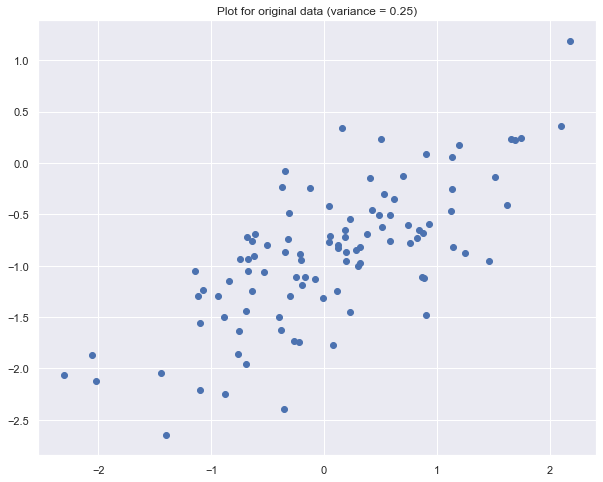

In [134]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y)
ax.set(title = "Plot for original data (variance = 0.25)", xlim = ax.get_xlim())

While there is definitely a positive linear relationship between `x` and `y`, there is some noise from the introduction of the error term.

## Part 5
**Fit a least squares linear model to predict `y` using `x`. Comment on the model obtained. How do $\hat{\beta}_0$ and $\hat{\beta}_1$ compare to $\beta_0$ and $\beta_1$?**

In [135]:
# Using StatsModels
mod_orig = sm.OLS(y, sm.add_constant(x))
res_orig = mod_orig.fit()
print(res_orig.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     107.0
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.20e-17
Time:                        16:10:32   Log-Likelihood:                -65.124
No. Observations:                 100   AIC:                             134.2
Df Residuals:                      98   BIC:                             139.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9265      0.047    -19.717      0.0

In [136]:
# Using ExtendedLinearRegression
reg_orig = ExtendedLinearRegression()
stats_orig = reg_orig.detailed_linear_regression(x, y)

In [137]:
np.round(stats_orig["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9265,0.047,-19.7173,0.0
1,0.5477,0.053,10.3417,0.0


In [138]:
np.round(stats_orig["oa_stats"], 4)

Residual standard error      0.4688
R-squared                    0.5218
F-statistic                106.9518
F-test p-value               0.0000
dtype: float64

The least squares regression model to predict `y` using `x` has the form $\hat{Y} = -0.9265 + 0.5477X$, which is quite close to the true relationship $Y = -1 + 0.5X + \epsilon$. The p-values of essentially zero for $\beta_0$ and $\beta_1$ provide strong evidence to reject the null hypotheses $H_0: \beta_j = 0$ for $j = 1, 2$. We also note, however, that $R^2 = 0.5218$, which means that the linear regression model explains only just over half of the variation in $Y$ found in the data. Lastly, the residual standard error is 0.4688.

## Part 6
**Display the least squares regression line on the scatterplot obtained in Part 4. Draw the population regression line on the plot, in a different color. Use the `legend()` command to create an appropriate legend.**

[(-2.5318083805455784, 2.415845090198457)]

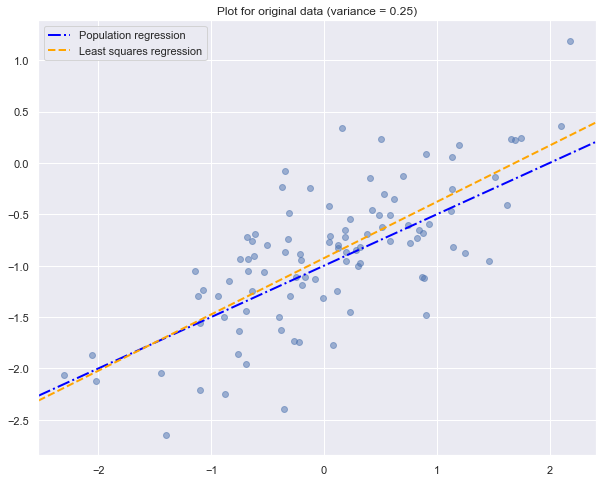

In [139]:
# Generate scatterplot
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y, alpha = 0.5)
ax.set(title = "Plot for original data (variance = 0.25)")
xlim = ax.get_xlim()

# Generate population regression line
x_vals = np.array(xlim)
y_pop = -1 + 0.5*x_vals
ax.plot(x_vals, y_pop, label = "Population regression", color = "blue", linestyle = "-.", linewidth = 2)

# Generate least squares regression line
y_reg = reg_orig.predict(x_vals.reshape(-1, 1))
ax.plot(x_vals, y_reg, label = "Least squares regression", color = "orange", linestyle = "--", linewidth = 2)

ax.legend(loc = "best")
ax.set(xlim = xlim)

## Part 7
**Now fit a polynomial regression model that predicts `y` using `x` and `x^2`. Is there evidence that the quadratic term improves the model fit? Explain your answer.**

In [140]:
# Use PolynomialFeatures transformer to generate NumPy array with x and x^2
poly = PolynomialFeatures(degree = 2, include_bias = True)
x_sq = poly.fit_transform(x)

In [141]:
# Using StatsModels
quad_mod = sm.OLS(y, x_sq)
quad_res = quad_mod.fit()
print(quad_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     52.96
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.83e-16
Time:                        16:10:33   Log-Likelihood:                -65.107
No. Observations:                 100   AIC:                             136.2
Df Residuals:                      97   BIC:                             144.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9325      0.058    -16.158      0.0

In [142]:
# Using ExtendedLinearRegression
# Since we had the PolynomialFeatures transformer already include the bias (intercept) column
# we set fit_intercept to False in order to avoid computing an extraneous intercept
quad_reg = ExtendedLinearRegression(fit_intercept = False)
quad_stats = quad_reg.detailed_linear_regression(x_sq, y)

In [143]:
np.round(quad_stats["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9325,0.0577,-16.1580,0.0000
1,0.5468,0.0535,10.2289,0.0000
2,0.0077,0.0425,0.1813,0.8565


In [144]:
np.round(quad_stats["oa_stats"], 4)

Residual standard error     0.4711
R-squared                   0.5220
F-statistic                35.3097
F-test p-value              0.0000
dtype: float64

While the polynomial regression model that predicts $Y$ using $X$ and $X^2$ has a slightly lower residual standard error value (0.4711 vs. 0.4688) and slightly higher $R^2$ value (0.5220 vs. 0.5218) compared to the linear model using just $X$, the p-value for the coefficient of $X^2$ is 0.8585. This means that even though the inclusion of the quadratic term slightly improved the model fit in this situation, there isn't sufficient evidence to reject the null hypothesis $H_0: \beta_2 = 0$. Thus, the improved model fit is likely a result of fitting more closely to the noise in the data from the presence of $\epsilon$ in the true relationship.

## Part 8
**Repeat Part 1-7 after modifying the data generation process in such a way that there is *less* noise in the data. The model described in Part 3 should remain the same. You can do this by decreasing the variance of the normal distribution used to generate the error term $\epsilon$ in Part 2. Describe your results.**

In [145]:
eps_less_noise = np.random.normal(loc = 0.0, scale = 0.25, size = (100, 1))
y_less_noise = -1 + 0.5*x + eps_less_noise

[(-2.5318083805455784, 2.415845090198457),
 Text(0.5, 1.0, 'Plot for with less noise (variance = 0.0625)')]

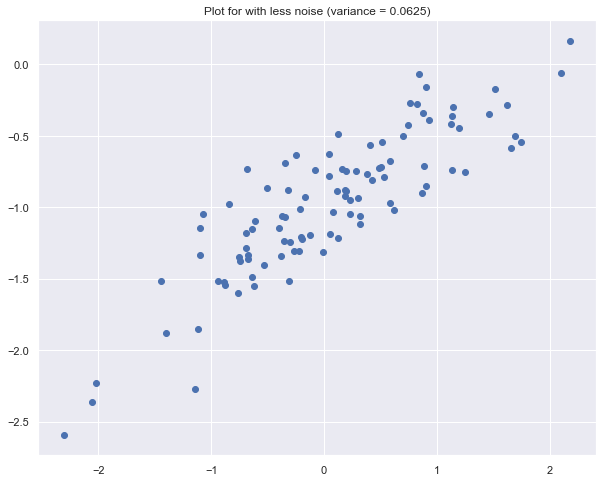

In [146]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y_less_noise)
ax.set(title = "Plot for with less noise (variance = 0.0625)", xlim = ax.get_xlim())

Compared to the plot from Part 3, there is clearly less noise in the data. This results in the points being more tightly clustered around the line $Y = -1 + 0.5X$.

In [147]:
# Using StatsModels
mod_less_noise = sm.OLS(y_less_noise, sm.add_constant(x))
res_less_noise = mod_less_noise.fit()
print(res_less_noise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     292.1
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           3.69e-31
Time:                        16:10:33   Log-Likelihood:                -3.6914
No. Observations:                 100   AIC:                             11.38
Df Residuals:                      98   BIC:                             16.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9969      0.025    -39.216      0.0

In [148]:
# Using ExtendedLinearRegression
reg_less_noise = ExtendedLinearRegression()
stats_less_noise = reg_less_noise.detailed_linear_regression(x, y_less_noise)

In [149]:
np.round(stats_less_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9969,0.0254,-39.2162,0.0
1,0.4897,0.0287,17.0923,0.0


In [150]:
np.round(stats_less_noise["oa_stats"], 4)

Residual standard error      0.2536
R-squared                    0.7488
F-statistic                292.1460
F-test p-value               0.0000
dtype: float64

The least squares regression model to predict `y` using `x` has the form $\hat{Y} = -0.9969 + 0.4897X$, which is again is quite close to the true relationship $Y = -1 + 0.5X + \epsilon$. The p-values of essentially zero for $\beta_0$ and $\beta_1$ provide strong evidence to reject the null hypotheses $H_0: \beta_j = 0$ for $j = 1, 2$. We also note that now $R^2 = 0.7488$, which means that the linear regression model explains about 75% of the variation in $Y$ found in the less noisy data. This is a big improvement from the $R^2$ value of 0.5218 when using the original, noisier $Y$. In addition, the residual standard error value of 0.2536 is also an improvement over the value of 0.4688 from the original data.

[(-2.5318083805455784, 2.415845090198457)]

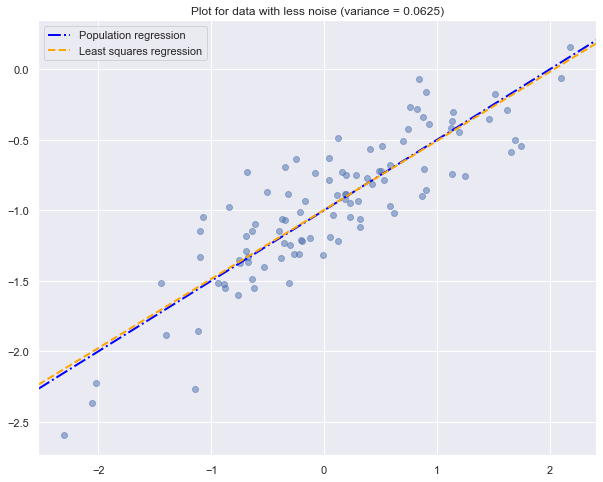

In [151]:
# Generate scatterplot
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y_less_noise, alpha = 0.5)
ax.set(title = "Plot for data with less noise (variance = 0.0625)")
xlim = ax.get_xlim()

# Generate population regression line
x_vals = np.array(xlim)
y_pop = -1 + 0.5*x_vals
ax.plot(x_vals, y_pop, label = "Population regression", color = "blue", linestyle = "-.", linewidth = 2)

# Generate least squares regression line
y_reg = reg_less_noise.predict(x_vals.reshape(-1, 1))
ax.plot(x_vals, y_reg, label = "Least squares regression", color = "orange", linestyle = "--", linewidth = 2)

ax.legend(loc = "best")
ax.set(xlim = xlim)

In [152]:
# Using StatsModels
quad_mod_less_noise = sm.OLS(y_less_noise, x_sq)
quad_res_less_noise = quad_mod_less_noise.fit()
print(quad_res_less_noise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     161.8
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.26e-31
Time:                        16:10:34   Log-Likelihood:                0.57989
No. Observations:                 100   AIC:                             4.840
Df Residuals:                      97   BIC:                             12.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9463      0.030    -31.627      0.0

In [153]:
# Using ExtendedLinearRegression
# Since we had the PolynomialFeatures transformer already include the bias (intercept) column
# we set fit_intercept to False in order to avoid computing an extraneous intercept
quad_reg_less_noise = ExtendedLinearRegression(fit_intercept = False)
quad_stats_less_noise = quad_reg_less_noise.detailed_linear_regression(x_sq, y_less_noise)

In [154]:
np.round(quad_stats_less_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9463,0.0299,-31.6267,0.0000
1,0.4973,0.0277,17.9438,0.0000
2,-0.0649,0.0221,-2.9412,0.0041


In [155]:
np.round(quad_stats_less_noise["oa_stats"], 4)

Residual standard error      0.2443
R-squared                    0.7694
F-statistic                107.8678
F-test p-value               0.0000
dtype: float64

With less noisy data the polynomial regression model that predicts $Y$ using $X$ and $X^2$ has a slightly lower residual standard error value (0.2443 vs. 0.2536) compared to the linear model using just $X$. The model using $X^2$ also has a slightly higher $R^2$ value of 0.7694. The p-value for the coefficient of $X^2$ is 0.0041, which is much lower than the value of 0.8565 for the polynomial regression with the original data. This means that in with this particular set of data, there is some evidence that the inclusion of $X^2$ improved the model fit. In addition there somewhat strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$. This isn't what I expected, and I think it is due to chance, since using a different random seed at the beginning of the problem (such as 312) gives more expected results of a high p-value. With a different random seed, the results we get make more sense, since with less noise the data lies closer to the true linear relationship. For more details, see the addendum after Part 10.

## Part 9
**Repeat Part 1-7 after modifying the data generation process in such a way that there is *more* noise in the data. The model described in Part 3 should remain the same. You can do this by increasing the variance of the normal distribution used to generate the error term $\epsilon$ in Part 2. Describe your results.**

In [156]:
eps_more_noise = np.random.normal(loc = 0.0, scale = 1, size = (100, 1))
y_more_noise = -1 + 0.5*x + eps_more_noise

[(-2.5318083805455784, 2.415845090198457),
 Text(0.5, 1.0, 'Plot for with more noise (variance = 1)')]

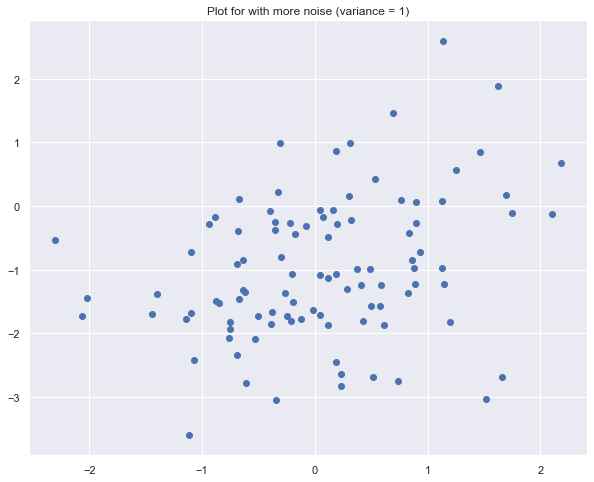

In [157]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y_more_noise)
ax.set(title = "Plot for with more noise (variance = 1)", xlim = ax.get_xlim())

Compared to the plot from Part 3, there is clearly more noise in the data. This results in the points being very spread out from the line $Y = -1 + 0.5X$. While there is a positive association between `x` and `y`, it would be quite difficult to determine the true values of $\beta_0$ and $\beta_1$ if we didn't already know them.

In [158]:
# Using StatsModels
mod_more_noise = sm.OLS(y_more_noise, sm.add_constant(x))
res_more_noise = mod_more_noise.fit()
print(res_more_noise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     10.62
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00154
Time:                        16:10:35   Log-Likelihood:                -147.75
No. Observations:                 100   AIC:                             299.5
Df Residuals:                      98   BIC:                             304.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0140      0.107     -9.445      0.0

In [159]:
# Using ExtendedLinearRegression
reg_more_noise = ExtendedLinearRegression()
stats_more_noise = reg_more_noise.detailed_linear_regression(x, y_more_noise)

In [160]:
np.round(stats_more_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-1.0140,0.1074,-9.4448,0.0000
1,0.3943,0.1210,3.2590,0.0015


In [161]:
np.round(stats_more_noise["oa_stats"], 4)

Residual standard error     1.0711
R-squared                   0.0978
F-statistic                10.6211
F-test p-value              0.0015
dtype: float64

The least squares regression model to predict `y` using `x` has the form $\hat{Y} = -1.0140 + 0.3943X$, which is still is fairly close to the true relationship $Y = -1 + 0.5X + \epsilon$. The p-values of essentially zero for $\beta_0$ and $\beta_1$ provide strong evidence to reject the null hypotheses $H_0: \beta_j = 0$ for $j = 1, 2$. We also note that now $R^2 = 0.0978$, which means that the linear regression model only explains less than 10% of the variation in $Y$ found in the less noisy data. This is a sharp decrease from the $R^2$ value of 0.5218 when using the original $Y$, which is less noisy. In addition, the residual standard error value of 1.0711 is larger compared to the value of 0.4688 from the original data.

[(-2.5318083805455784, 2.415845090198457)]

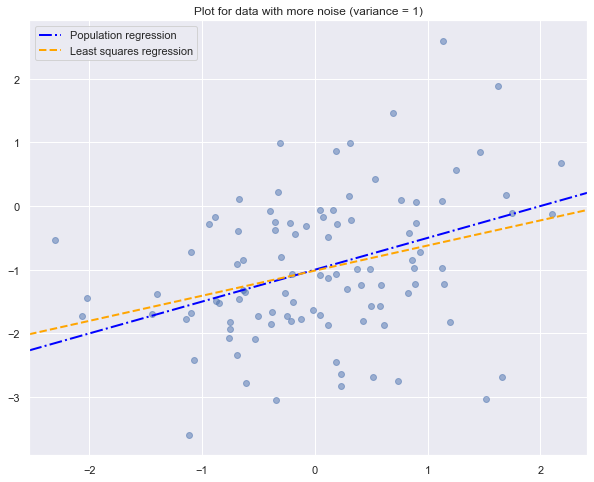

In [162]:
# Generate scatterplot
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y_more_noise, alpha = 0.5)
ax.set(title = "Plot for data with more noise (variance = 1)")
xlim = ax.get_xlim()

# Generate population regression line
x_vals = np.array(xlim)
y_pop = -1 + 0.5*x_vals
ax.plot(x_vals, y_pop, label = "Population regression", color = "blue", linestyle = "-.", linewidth = 2)

# Generate least squares regression line
y_reg = reg_more_noise.predict(x_vals.reshape(-1, 1))
ax.plot(x_vals, y_reg, label = "Least squares regression", color = "orange", linestyle = "--", linewidth = 2)

ax.legend(loc = "best")
ax.set(xlim = xlim)

In [163]:
# Using StatsModels
quad_mod_more_noise = sm.OLS(y_more_noise, x_sq)
quad_res_more_noise = quad_mod_more_noise.fit()
print(quad_res_more_noise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5.773
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00428
Time:                        16:10:36   Log-Likelihood:                -147.27
No. Observations:                 100   AIC:                             300.5
Df Residuals:                      97   BIC:                             308.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0868      0.131     -8.281      0.0

In [164]:
# Using ExtendedLinearRegression
# Since we had the PolynomialFeatures transformer already include the bias (intercept) column
# we set fit_intercept to False in order to avoid computing an extraneous intercept
quad_reg_more_noise = ExtendedLinearRegression(fit_intercept = False)
quad_stats_more_noise = quad_reg_less_noise.detailed_linear_regression(x_sq, y_more_noise)

In [165]:
np.round(quad_stats_more_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-1.0868,0.1312,-8.2806,0.0000
1,0.3834,0.1216,3.1536,0.0021
2,0.0934,0.0967,0.9657,0.3366


In [166]:
np.round(quad_stats_more_noise["oa_stats"], 4)

Residual standard error    1.0714
R-squared                  0.1064
F-statistic                3.8488
F-test p-value             0.0119
dtype: float64

With more noisy data the polynomial regression model that predicts $Y$ using $X$ and $X^2$ has essentially the same residual standard error value (1.0714 vs. 1.0711) and a somewhat higher $R^2$ value (0.1064 vs. 0.0978) compared to the linear model using just $X$. This means that there is some evidence that the inclusion of $X^2$ improved the model fit. However, since we know that the true relationship is linear and just has a lot of noise, the improvements are coming from the fact that the improved flexibility with including $X^2$ allows the model to follow the noise more closely. The p-value for the coefficient of $X^2$ is 0.3366, which is much lower than the value of 0.8565 for the polynomial regression with the original data. Even though this is an improvement, that value is still not sufficient evidence to reject the null hypothesis $H_0: \beta_2 = 0$.

## Part 10
**What are the confidence intervals for $\beta_0$ and $\beta_1$ based on the original data set, the noisier data set, and the less noisy data set? Comment on your results.**

In [167]:
reg_less_noise.param_conf_int()

,2.5%,97.5%
0,-1.047370,-0.946475
1,0.432876,0.546595


In [168]:
reg_orig.param_conf_int()

,2.5%,97.5%
0,-1.019741,-0.833246
1,0.442613,0.652814


In [169]:
reg_more_noise.param_conf_int()

,2.5%,97.5%
0,-1.227007,-0.800916
1,0.154222,0.634472


As we go from less noise from more noise, the confidence intervals for $\beta_0$ and $\beta_1$ become wider and wider.

## Addendum
In this addendum, I re-visit the comparisons done in Part 8 after regenerating the noise (and also using a different random seed in doing so) to emphasize that the results I got above were likely due to chance.

In [170]:
np.random.seed(312)
eps_less_noise = np.random.normal(loc = 0.0, scale = 0.25, size = (100, 1))
y_less_noise = -1 + 0.5*x + eps_less_noise

In [171]:
# Using ExtendedLinearRegression
reg_less_noise = ExtendedLinearRegression()
stats_less_noise = reg_less_noise.detailed_linear_regression(x, y_less_noise)

In [172]:
np.round(stats_less_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9680,0.0243,-39.7766,0.0
1,0.5269,0.0274,19.2090,0.0


In [173]:
np.round(stats_less_noise["oa_stats"], 4)

Residual standard error      0.2428
R-squared                    0.7901
F-statistic                368.9859
F-test p-value               0.0000
dtype: float64

The least squares regression model to predict `y` using `x` has the form $\hat{Y} = -0.9680 + 0.5269X$, which is again is quite close to the true relationship $Y = -1 + 0.5X + \epsilon$. The p-values of essentially zero for $\beta_0$ and $\beta_1$ provide strong evidence to reject the null hypotheses $H_0: \beta_j = 0$ for $j = 1, 2$. We also note that now $R^2 = 0.7901$, which means that the linear regression model explains about 79% of the variation in $Y$ found in the less noisy data. This is a big improvement from the $R^2$ value of 0.5218 when using the original, noisier $Y$. In addition, the residual standard error value of 0.2428 is also an improvement over the value of 0.4688 from the original data.

In [174]:
# Using ExtendedLinearRegression
# Since we had the PolynomialFeatures transformer already include the bias (intercept) column
# we set fit_intercept to False in order to avoid computing an extraneous intercept
quad_reg_less_noise = ExtendedLinearRegression(fit_intercept = False)
quad_stats_less_noise = quad_reg_less_noise.detailed_linear_regression(x_sq, y_less_noise)

In [175]:
np.round(quad_stats_less_noise["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-0.9747,0.0299,-32.6301,0.0000
1,0.5259,0.0277,19.0060,0.0000
2,0.0086,0.0220,0.3899,0.6974


In [176]:
np.round(quad_stats_less_noise["oa_stats"], 4)

Residual standard error      0.2439
R-squared                    0.7905
F-statistic                121.9818
F-test p-value               0.0000
dtype: float64

With less noisy data the polynomial regression model that predicts $Y$ using $X$ and $X^2$ has a slightly higher residual standard error value (0.2439 vs. 0.2428) compared to the linear model using just $X$. The model using $X^2$ also has a slightly higher $R^2$ value of 0.7905. The p-value for the coefficient of $X^2$ is 0.3899, which is lower than the value of 0.8565 for the polynomial regression with the original data, but it isn't evidence to reject the null hypothesis $H_0: \beta_2 = 0$. This indicates that the inclusion of the quadratic term did little, if anything, to improve the performance of the model. This is expected since with less noise the data is closer to the actual linear relationsihp.

# Applied Exercise 7
**This problem focuses on the *collinearity* problem.**

## Part 1
**Perform the following commands in Python:**

```
> np.random.seed(1)
> x1 = np.random.rand(100, 1)
> x2 = 0.5*x1 + np.random.normal(size = (100, 1))/10
> y = 2 + 2*x1 + 0.3*x2 + np.random.normal(size = (100, 1))
```

**The last line corresponds to creating a linear model in which `y` is a function of `x1` and `x2`. Write out the form of the linear model. What are the regression coefficients?**

***Note that `np.random.rand(d_1, ..., d_n)` generates an n-dimensional array with the given dimensions and each entry a random float from a uniform distribution on $[0, 1)$. This is a convenience function for `np.random.uniform(low, high, size)`.***

In [177]:
np.random.seed(1)
x1 = np.random.rand(100, 1)
x2 = 0.5*x1 + np.random.normal(size = (100, 1))/10
y = 2 + 2*x1 + 0.3*x2 + np.random.normal(size = (100, 1))

The linear model has the form $Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \epsilon$, where the regression coefficients are $\beta_0 = 2$, $\beta_1 = 2$, and $\beta_2 = 0.3$.

## Part 2
**What is the correlation between `x1` and `x2`? Create a scatterplot displaying the relationship between the variables.**

In [178]:
np.corrcoef(x1, x2, rowvar = False)

array([[1.        , 0.83905962],
       [0.83905962, 1.        ]])

The correlation between `x1` and `x2` is approximately 0.839.

[Text(0, 0.5, 'x2'), Text(0.5, 0, 'x1')]

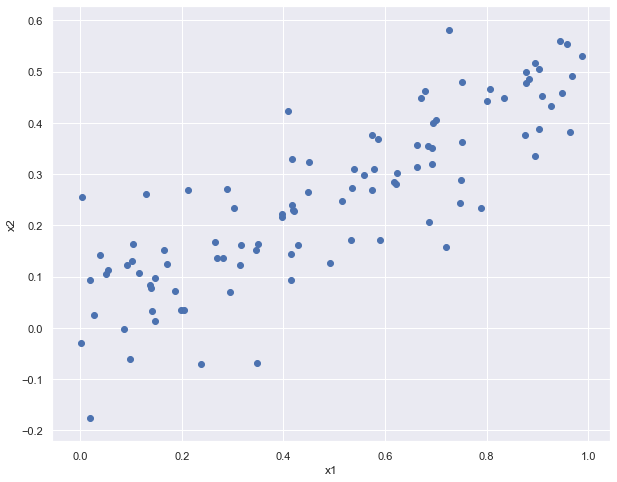

In [179]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x1, x2)
ax.set(xlabel = "x1", ylabel = "x2")

## Part 3
**Using this data, fit a least squares regression to predict `y` using `x1` and `x2`. Describe the results obtained. What are $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$? How do these relate to the true $\beta_0$, $\beta_1$, and $\beta_2$? Can you reject the null hypothesis $H_0: \beta_1 = 0$? How about the null hypothesis $H_0: \beta_2 = 0$?**

In [180]:
# Using StatsModels
exog_both = sm.add_constant(np.hstack((x1, x2)))
mod_both = sm.OLS(y, exog_both)
res_both = mod_both.fit()
print(res_both.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           4.40e-07
Time:                        16:10:37   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1893      0.199     11.021      0.0

In [181]:
# Using ExtendedLinearRegression
reg_both = ExtendedLinearRegression()
stats_both = reg_both.detailed_linear_regression(np.hstack((x1, x2)), y)

In [182]:
np.round(stats_both["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.1893,0.1987,11.0206,0.0000
1,0.7046,0.6368,1.1066,0.2712
2,2.5024,1.1404,2.1943,0.0306


In [183]:
np.round(stats_both["oa_stats"], 4)

Residual standard error     1.0199
R-squared                   0.2605
F-statistic                17.0856
F-test p-value              0.0000
dtype: float64

In [184]:
reg_both.param_conf_int()

,2.5%,97.5%
0,1.795010,2.583559
1,-0.559175,1.968432
2,0.238962,4.765848


After fitting a least squares regression to predict `y` using `x1` and `x2`, we get a model of the form $\hat{Y} = 2.1893 + 0.7406X_1 + 2.5024X_2$. In other words, $\hat{\beta}_0 = 2.1893$, $\hat{\beta}_1 = 0.7406$, and $\hat{\beta}_2 = 2.5024$. While $\hat{\beta}_0$ is a fairly reasonable estimate for the true value of $\beta_0 = 2$, the estimates for the other coefficient values are quite poor. The value of $\hat{\beta}_1$ less than half of the true value of $\beta_1$, while the value of $\hat{\beta}_2$ is even further off, being more than eight times true value of $\beta_2$. With a p-value of 0.2712 for $\hat{\beta}_1$, we don't have sufficient evidence to reject the null hypothesis $H_0: \beta_1 = 0$. We can, however, reject the null hypothesis $H_0: \beta_2 = 0$ at the 5% level, as the p-value for $\hat{\beta}_2$ is 0.0306. Looking more closely at the 95% confidence intervals for the parameter coefficiencts, we see that while the interval for $\hat{\beta}_1$ falls just short of the true value of $\beta_1$, the interval for $\hat{\beta}_2$ does contain the true value of $\beta_2$. This is due to the relatively high standard error values relative to the sizes of the coefficient estimates.

## Part 4
**Now fit a least squares regression to predict `y` using only `x1`. Comment on your results. Can you reject the null hypothesis $H_0: \beta_1 = 0$?**

In [185]:
# Using StatsModels
mod_x1 = sm.OLS(y, sm.add_constant(x1))
res_x1 = mod_x1.fit()
print(res_x1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           6.68e-07
Time:                        16:10:37   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2486      0.201     11.209      0.0

In [186]:
# Using ExtendedLinearRegression
reg_x1 = ExtendedLinearRegression()
stats_x1 = reg_x1.detailed_linear_regression(x1, y)

In [187]:
np.round(stats_x1["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.2486,0.2006,11.2092,0.0
1,1.8770,0.3531,5.3157,0.0


In [188]:
np.round(stats_x1["oa_stats"], 4)

Residual standard error     1.0395
R-squared                   0.2238
F-statistic                28.2565
F-test p-value              0.0000
dtype: float64

In [189]:
reg_x1.param_conf_int()

,2.5%,97.5%
0,1.850493,2.646669
1,1.176264,2.577709


When we fit a model predicting `y` using only `x1`, we get a model of the form $\hat{Y} = 2.2486 + 1.8770X_1$. Here, while the value of $\hat{\beta}_0 = 2.2486$ is further from the actual value of $\beta_0$, the value of $\hat{\beta}_1 = 1.8770$ is much closer to the actual value of $\beta_1$. Moreover, since the standard error for $\hat{\beta}_1$ has almost been cut in half, dropping from 0.6368 in Part 3 to 0.3531, the p-value has reduced dramatically to essentially zero. This provides much stronger evidence for rejecting the null hypothesis $H_0: \beta_1 = 0$.

## Part 5
**Now fit a least squares regression to predict `y` using only `x2`. Comment on your results. Can you reject the null hypothesis $H_0: \beta_2 = 0$?**

In [190]:
# Using StatsModels
mod_x2 = sm.OLS(y, sm.add_constant(x2))
res_x2 = mod_x2.fit()
print(res_x2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.09e-07
Time:                        16:10:37   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2655      0.187     12.145      0.0

In [191]:
# Using ExtendedLinearRegression
reg_x2 = ExtendedLinearRegression()
stats_x2 = reg_x2.detailed_linear_regression(x2, y)

In [192]:
np.round(stats_x2["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.2655,0.1865,12.1452,0.0
1,3.5613,0.6212,5.7334,0.0


In [193]:
np.round(stats_x2["oa_stats"], 4)

Residual standard error     1.0210
R-squared                   0.2512
F-statistic                32.8713
F-test p-value              0.0000
dtype: float64

In [194]:
reg_x2.param_conf_int()

,2.5%,97.5%
0,1.895349,2.635703
1,2.328623,4.793930


When we fit a model predicting `y` using only `x2`, we get a model of the form $\hat{Y} = 2.2655 + 3.5613X_2$. Here, while the value of $\hat{\beta}_0 = 2.2655$ isn't too far off from the actual value of $\beta_0$, the value of $\hat{\beta}_2 = 3.5613$ is more than ten times the true value of $\beta_2$. However, since the standard error for $\hat{\beta}_2$ has almost been cut in half, dropping from 1.1404 in Part 3 to 0.6212, the p-value has reduced dramatically to essentially zero. This provides strong evidence for rejecting the null hypothesis $H_0: \beta_2 = 0$.

## Part 6
**Do the results obtained in Part 3-5 contradict each other? Explain your answer.**

Even though in Part 3 we didn't have enough evidence to reject the null hypothesis $H_0: \beta_2 = 0$, but had strong evidence to do so in Part 5, the results from Part 3-5 do not contradict each other. This is due to the strong collinearity between `x1` and `x2`, which increases the standard error for coeffiecient estimates in least squares regression to grow. This in turn reduces the *power* of the hypothesis test, which in this context is the probability of correctly detecting that the true values of $\beta_1$ and $\beta_2$ are non-zero. We recall that failing to reject the null hypothesis $H_0: \beta_j = 0$ doesn't mean that the $\beta_j = 0$ in the actual model. It simply means that there isn't enough evidence to confidently conclude $\beta_j \neq 0$ with the data we have available to us.

## Part 7
**Now suppose we obtain one additional observation, which was unfortunately mismeasured.**

```
> x1_new = np.concatenate((x1, [[0.1]]))
> x2_new = np.concatenate((x2, [[0.8]]))
> y_new = np.concatenate((y, [[6]]))
```

**Re-fit the linear models from Part 3-5 using this new data. What effect does this new observation have on each of the models? In each model is this observation an outlier? A high-leverage point? Both? Explain your answers.**

In [195]:
x1_new = np.concatenate((x1, [[0.1]]))
x2_new = np.concatenate((x2, [[0.8]]))
y_new = np.concatenate((y, [[6]]))

In [196]:
np.corrcoef(x1_new, x2_new, rowvar = False)

array([[1.        , 0.74883922],
       [0.74883922, 1.        ]])

In [197]:
# Using ExtendedLinearRegression
new_reg_both = ExtendedLinearRegression()
new_stats_both = new_reg_both.detailed_linear_regression(np.hstack((x1_new, x2_new)), y_new)

In [198]:
np.round(new_stats_both["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.1996,0.1992,11.0407,0.0000
1,0.2200,0.5202,0.4230,0.6732
2,3.4392,0.8917,3.8570,0.0002


In [199]:
np.round(new_stats_both["oa_stats"], 4)

Residual standard error     1.0236
R-squared                   0.2890
F-statistic                19.9189
F-test p-value              0.0000
dtype: float64

In [200]:
new_reg_both.param_conf_int()

,2.5%,97.5%
0,1.804222,2.594928
1,-0.812313,1.252365
2,1.669677,5.208698


In [201]:
# Compute residuals
X = np.hstack((x1_new, x2_new))
prediction = new_reg_both.predict(X)
residuals = (y_new - prediction).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

In [202]:
studentized_residuals[-1]

1.3053732832379705

In [203]:
leverage_vals[-1]

0.40916108676876123

For the model involving both `x1` and `x2`, adding the new observation, while not really affecting the value of $\hat{\beta}_0$, had a large effect on the values of $\hat{\beta}_1$ and $\hat{\beta}_2$. The original regression model from Part 3 was $\hat{Y} = 2.1893 + 0.7406X_1 + 2.5024X_2$, with p-values of 0.2712 for $\hat{\beta}_1$ and 0.0306 for $\hat{\beta_2}$. After including the the new observation, the model is $\hat{Y} = 2.1996 + 0.2200X_1 + 3.4392X_2$, with p-values of 0.6732 for $\hat{\beta}_1$ and 0.0002 for $\hat{\beta}_2$. On top of $\hat{\beta}_1$ being cut down to a third and $\hat{\beta}_2$ being multiplied by a factor of about 1.5 of their values from Part 3, there is now no even less evidence to reject the null hypothesis $H_0: \beta_1 = 0$ while there is even stronger evidence to reject the null hypothesis $H_0: \beta_2 = 0$ (enough to reject at the 0.1% level). In this model, the new observation has a studentized residual of 1.3054. This falls short of our threshold of 3 to strongly consider the value an outlier, but it is still a moderate value and is certainly large enough to have decent influence on the model. The leverage value of this new observation is 0.4092, which is quite high compared to the average value of $(p + 1)/n = 3/101 = 0.0297$. Thus, I would consider the new observation to be one with high leverage and also a moderate studentized residual (though not large enough to be strongly considered an outlier).

In [204]:
# Using ExtendedLinearRegression
new_reg_x1 = ExtendedLinearRegression()
new_stats_x1 = new_reg_x1.detailed_linear_regression(x1_new, y_new)

In [205]:
np.round(new_stats_x1["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.3583,0.2081,11.3306,0.0
1,1.7225,0.3681,4.6790,0.0


In [206]:
np.round(new_stats_x1["oa_stats"], 4)

Residual standard error     1.0930
R-squared                   0.1811
F-statistic                21.8930
F-test p-value              0.0000
dtype: float64

In [207]:
new_reg_x1.param_conf_int()

,2.5%,97.5%
0,1.945334,2.771317
1,0.992053,2.452992


In [208]:
# Compute residuals
X = x1_new
prediction = new_reg_x1.predict(X)
residuals = (y_new - prediction).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

In [209]:
studentized_residuals[-1]

3.2171030910350282

In [210]:
leverage_vals[-1]

0.026460664578732668

For the model involving only `x1`, adding the new observation, while changing the model from $\hat{Y} = 2.2486 + 1.8770X_1$ to $\hat{Y} = 2.3583 + 1.7225X_1$, didn't result in the same drastic change that we saw in the model involving both `x1` and `x2`. While the new observation, with a studentized residual of 3.2171 is a clear outlier, its leverage value of 0.02646 is right in line with the average leverage value of 0.0297 for all observations. That means the new observation is an outlier, but not a high leverage point.

In [211]:
# Using ExtendedLinearRegression
new_reg_x2 = ExtendedLinearRegression()
new_stats_x2 = new_reg_x2.detailed_linear_regression(x2_new, y_new)

In [212]:
np.round(new_stats_x2["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,2.2331,0.1820,12.2706,0.0
1,3.7216,0.5885,6.3238,0.0


In [213]:
np.round(new_stats_x2["oa_stats"], 4)

Residual standard error     1.0193
R-squared                   0.2877
F-statistic                39.9906
F-test p-value              0.0000
dtype: float64

In [214]:
new_reg_x2.param_conf_int()

,2.5%,97.5%
0,1.872020,2.594234
1,2.553881,4.889332


In [215]:
# Compute residuals
X = x2_new
prediction = new_reg_x2.predict(X)
residuals = (y_new - prediction).flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

In [216]:
studentized_residuals[-1]

0.8202755696165964

In [217]:
leverage_vals[-1]

0.10826648419714906

Similar to the model involving only `x1`, adding the new observation to the model involving `x2` didn't greatly change the coefficients from their values in Part 5. It only changed from $\hat{Y} = 2.2655 + 3.5613X_2$ to $\hat{Y} = 2.2331 + 3.7216X_2$, which again isn't the same drastic change that we saw in the model involving both `x1` and `x2`. While the new observation, with a studentized residual of 0.8203 is not an outlier, its leverage value of 0.1083 is more than triple the average leverage value of 0.0297 for all observations. That means the new observation not an outlier, but it is a high leverage point.

# Applied Exercise 8
**This problem involves the `Boston` data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set. In other words, per capita crime rate is the response, and the other variables are the predictors.**

I will be using the corrected Boston housing data set instead of the one that is part of the `MASS` library.

In [218]:
boston_filepath = "boston_corrected.csv"
boston = pd.read_csv(boston_filepath, index_col = ["TOWN", "TRACT"],
                    usecols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"])
boston.head()

CMEDV     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE  \
TOWN       TRACT                                                          
Nahant     2011    24.0  0.00632  18.0   2.31     0  0.538  6.575  65.2   
Swampscott 2021    21.6  0.02731   0.0   7.07     0  0.469  6.421  78.9   
           2022    34.7  0.02729   0.0   7.07     0  0.469  7.185  61.1   
Marblehead 2031    33.4  0.03237   0.0   2.18     0  0.458  6.998  45.8   
           2032    36.2  0.06905   0.0   2.18     0  0.458  7.147  54.2   

                     DIS  RAD  TAX  PTRATIO       B  LSTAT  
TOWN       TRACT                                            
Nahant     2011   4.0900    1  296     15.3  396.90   4.98  
Swampscott 2021   4.9671    2  242     17.8  396.90   9.14  
           2022   4.9671    2  242     17.8  392.83   4.03  
Marblehead 2031   6.0622    3  222     18.7  394.63   2.94  
           2032   6.0622    3  222     18.7  396.90   5.33

In [219]:
predictors = boston.columns.drop("CRIM")

## Part 1
**For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.**

In [220]:
linear_fits = {}
for pred in predictors:
    reg = ExtendedLinearRegression()
    linear_fits[pred] = reg.detailed_linear_regression(boston[pred].values.reshape(-1, 1), boston["CRIM"].values.reshape(-1, 1))

In [221]:
np.round(linear_fits["CMEDV"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,11.8354,0.9348,12.6608,0.0
1,-0.3649,0.0384,-9.4964,0.0


In [222]:
np.round(linear_fits["CMEDV"]["oa_stats"], 4)

Residual standard error     7.9298
R-squared                   0.1518
F-statistic                90.1816
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `CMEDV`, the p-value for the estimated coefficient of `CMEDV` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `CMEDV` and the response `CRIM`. In addition, the $R^2$ value of 0.1518 indicates that about 15% of the variation in `CRIM` is explained by this simple linear regression model.

In [223]:
np.round(linear_fits["ZN"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,4.4537,0.4172,10.6747,0.0
1,-0.0739,0.0161,-4.5938,0.0


In [224]:
np.round(linear_fits["ZN"]["oa_stats"], 4)

Residual standard error     8.4353
R-squared                   0.0402
F-statistic                21.1028
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `ZN`, the p-value for the estimated coefficient of `ZN` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `ZN` and the response `CRIM`. In addition, the $R^2$ value of 0.0402 indicates that about 4% of the variation in `CRIM` is explained by this simple linear regression model.

In [225]:
np.round(linear_fits["INDUS"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-2.0637,0.6672,-3.0930,0.0021
1,0.5098,0.0510,9.9908,0.0000


In [226]:
np.round(linear_fits["INDUS"]["oa_stats"], 4)

Residual standard error     7.8663
R-squared                   0.1653
F-statistic                99.8170
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `INDUS`, the p-value for the estimated coefficient of `INDUS` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `INDUS` and the response `CRIM`. In addition, the $R^2$ value of 0.1653 indicates that about 16% of the variation in `CRIM` is explained by this simple linear regression model.

In [227]:
np.round(linear_fits["CHAS"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.7444,0.3961,9.4530,0.0000
1,-1.8928,1.5061,-1.2567,0.2094


In [228]:
np.round(linear_fits["CHAS"]["oa_stats"], 4)

Residual standard error    8.5966
R-squared                  0.0031
F-statistic                1.5794
F-test p-value             0.2094
dtype: float64

In a simple linear regression of `CRIM` onto `CHAS`, the p-value for the estimated coefficient of `CHAS` is 0.2094. This means there isn't evidence of a statistically significant association between the predictor `CHAS` and the response `CRIM`. In addition, the $R^2$ value of 0.0031 indicates that about 0.31% of the variation in `CRIM` is explained by this simple linear regression model.

In [229]:
np.round(linear_fits["NOX"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-13.7199,1.6995,-8.073,0.0
1,31.2485,2.9992,10.419,0.0


In [230]:
np.round(linear_fits["NOX"]["oa_stats"], 4)

Residual standard error      7.8100
R-squared                    0.1772
F-statistic                108.5553
F-test p-value               0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `NOX`, the p-value for the estimated coefficient of `NOX` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `CMEDV` and the response `NOX`. In addition, the $R^2$ value of 0.1772 indicates that about 18% of the variation in `CRIM` is explained by this simple linear regression model.

In [231]:
np.round(linear_fits["RM"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,20.4818,3.3645,6.0877,0.0
1,-2.6841,0.5320,-5.0448,0.0


In [232]:
np.round(linear_fits["RM"]["oa_stats"], 4)

Residual standard error     8.4006
R-squared                   0.0481
F-statistic                25.4502
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `RM`, the p-value for the estimated coefficient of `RM` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `RM` and the response `CRIM`. In addition, the $R^2$ value of 0.0481 indicates that about 5% of the variation in `CRIM` is explained by this simple linear regression model.

In [233]:
np.round(linear_fits["AGE"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-3.7779,0.9440,-4.0021,0.0001
1,0.1078,0.0127,8.4628,0.0000


In [234]:
np.round(linear_fits["AGE"]["oa_stats"], 4)

Residual standard error     8.0566
R-squared                   0.1244
F-statistic                71.6194
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `AGE`, the p-value for the estimated coefficient of `AGE` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `AGE` and the response `CRIM`. In addition, the $R^2$ value of 0.1244 indicates that about 12% of the variation in `CRIM` is explained by this simple linear regression model.

In [235]:
np.round(linear_fits["DIS"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,9.4993,0.7304,13.0056,0.0
1,-1.5509,0.1683,-9.2135,0.0


In [236]:
np.round(linear_fits["DIS"]["oa_stats"], 4)

Residual standard error     7.9654
R-squared                   0.1441
F-statistic                84.8878
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `DIS`, the p-value for the estimated coefficient of `DIS` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `DIS` and the response `CRIM`. In addition, the $R^2$ value of 0.1441 indicates that about 14% of the variation in `CRIM` is explained by this simple linear regression model.

In [237]:
np.round(linear_fits["RAD"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-2.2872,0.4435,-5.1573,0.0
1,0.6179,0.0343,17.9982,0.0


In [238]:
np.round(linear_fits["RAD"]["oa_stats"], 4)

Residual standard error      6.7178
R-squared                    0.3913
F-statistic                323.9352
F-test p-value               0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `RAD`, the p-value for the estimated coefficient of `RAD` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `RAD` and the response `CRIM`. In addition, the $R^2$ value of 0.3913 indicates that about 39% of the variation in `CRIM` is explained by this simple linear regression model.

In [239]:
np.round(linear_fits["TAX"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-8.5284,0.8158,-10.4539,0.0
1,0.0297,0.0018,16.0994,0.0


In [240]:
np.round(linear_fits["TAX"]["oa_stats"], 4)

Residual standard error      6.9969
R-squared                    0.3396
F-statistic                259.1903
F-test p-value               0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `TAX`, the p-value for the estimated coefficient of `TAX` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `TAX` and the response `CRIM`. In addition, the $R^2$ value of 0.3396 indicates that about 34% of the variation in `CRIM` is explained by this simple linear regression model.

In [241]:
np.round(linear_fits["PTRATIO"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-17.6469,3.1473,-5.6071,0.0
1,1.1520,0.1694,6.8014,0.0


In [242]:
np.round(linear_fits["PTRATIO"]["oa_stats"], 4)

Residual standard error     8.2402
R-squared                   0.0841
F-statistic                46.2595
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `PTRATIO`, the p-value for the estimated coefficient of `PTRATIO` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `PTRATIO` and the response `CRIM`. In addition, the $R^2$ value of 0.0841 indicates that about 8% of the variation in `CRIM` is explained by this simple linear regression model.

In [243]:
np.round(linear_fits["B"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,16.5535,1.4259,11.6092,0.0
1,-0.0363,0.0039,-9.3670,0.0


In [244]:
np.round(linear_fits["B"]["oa_stats"], 4)

Residual standard error     7.9462
R-squared                   0.1483
F-statistic                87.7398
F-test p-value              0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `B`, the p-value for the estimated coefficient of `B` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `B` and the response `CRIM`. In addition, the $R^2$ value of 0.1483 indicates that about 15% of the variation in `CRIM` is explained by this simple linear regression model.

In [245]:
np.round(linear_fits["LSTAT"]["param_stats"], 4)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-3.3305,0.6938,-4.8007,0.0
1,0.5488,0.0478,11.4907,0.0


In [246]:
np.round(linear_fits["LSTAT"]["oa_stats"], 4)

Residual standard error      7.6645
R-squared                    0.2076
F-statistic                132.0351
F-test p-value               0.0000
dtype: float64

In a simple linear regression of `CRIM` onto `LSTAT`, the p-value for the estimated coefficient of `LSTAT` is essentially zero. This means there is strong evidence of a statistically significant association between the predictor `LSTAT` and the response `CRIM`. In addition, the $R^2$ value of 0.2076 indicates that about 21% of the variation in `CRIM` is explained by this simple linear regression model.

In summary, when performing individual simple linear regressions of `CRIM` onto each predictor, there was strong statistical evidence of an association with the response `CRIM` for all of the variables execpt for `CHAS`. In addition, each individual simple linear regression model had an $R^2$ value of less than 0.5. The highest of these was the value for the regression onto `RAD`, the index of accessibility to radial highways, at 0.3913, and the lowest was the value for the regression onto `CHAS`, the dummy variable representing whether or not a town borders the Charles River, at 0.0031. 

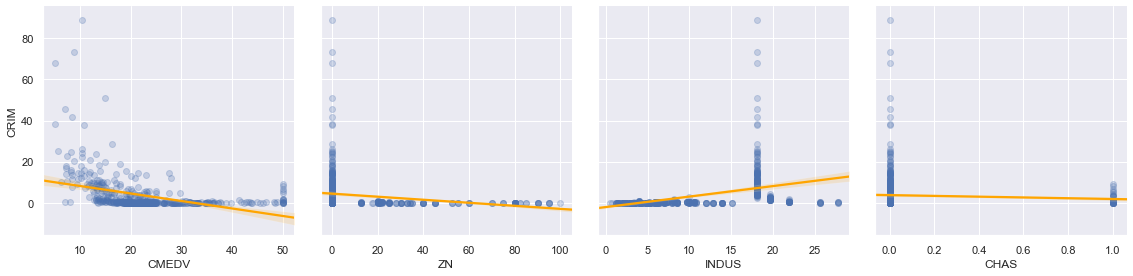

In [247]:
g = sns.PairGrid(boston, x_vars = predictors[:4], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})

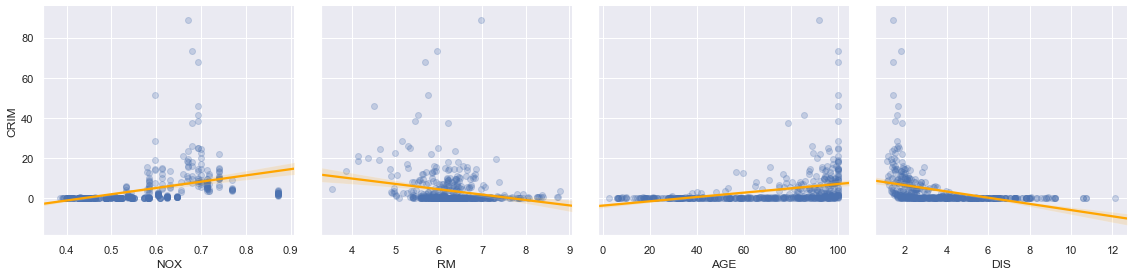

In [248]:
g = sns.PairGrid(boston, x_vars = predictors[4:8], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})

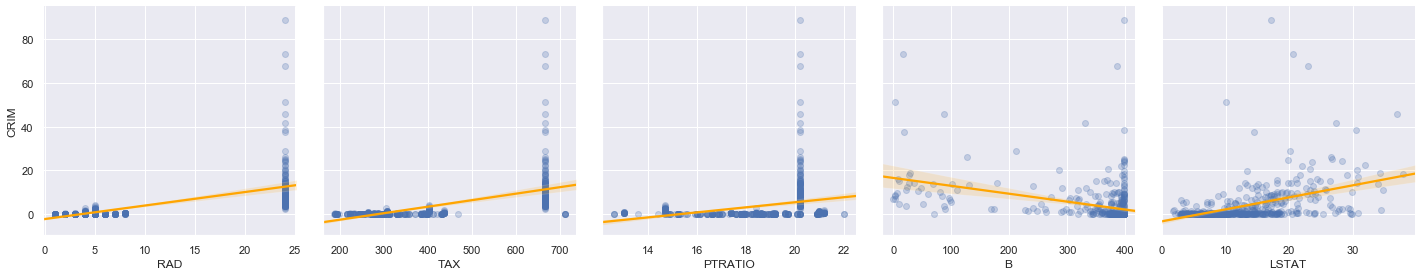

In [249]:
g = sns.PairGrid(boston, x_vars = predictors[8:13], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})

## Part 2
**Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0: \beta_j = 0$?**

In [250]:
# Using StatsModels
all_mod = sm.OLS(boston["CRIM"], sm.add_constant(boston[predictors]))
all_res = all_mod.fit()
print(all_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     31.45
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.70e-56
Time:                        16:10:49   Log-Likelihood:                -1653.3
No. Observations:                 506   AIC:                             3335.
Df Residuals:                     492   BIC:                             3394.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0296      7.241      2.352      0.0

C:\Users\Kyle\Anaconda3\envs\islr\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [251]:
# Using ExtendedLinearRegression
all_reg = ExtendedLinearRegression().detailed_linear_regression(boston[predictors], boston["CRIM"].values.reshape(-1, 1))

In [252]:

np.round(all_reg["param_stats"].set_index(predictors.insert(0,"intercept")), 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
intercept,17.02958,7.24072,2.35192,0.01906
CMEDV,-0.19917,0.06108,-3.26066,0.00119
ZN,0.04514,0.01875,2.40718,0.01643
INDUS,-0.06334,0.08342,-0.75919,0.44809
CHAS,-0.74780,1.18060,-0.63341,0.52676
NOX,-10.31616,5.27815,-1.95450,0.05119
RM,0.42704,0.61326,0.69634,0.48653
AGE,0.00143,0.01793,0.07970,0.93651
DIS,-0.99306,0.28261,-3.51383,0.00048
RAD,0.58802,0.08807,6.67641,0.00000


In [253]:
np.round(all_reg["oa_stats"], 4)

Residual standard error     6.4403
R-squared                   0.4538
F-statistic                31.4471
F-test p-value              0.0000
dtype: float64

When fitting a multiple regression model to predict `CRIM` using all of the predictors, the (adjusted) $R^2$ value is 0.4394. This is an increase from the largest $R^2$ value among all of the individual simple linear regression models, which was 0.3913. That means that the model using all of the predictors does a better job of explaining the variation in `CRIM` values compared to any of the simple linear regression models. In this model, there are fewer predictors for which we have sufficient evidence to reject the null hypothesis $H_0: \beta_j = 0$, and this also depends on the significance level we wish to use. Only `RAD`, with a p-value of essentially zero, has very strong evidence to reject that null hypothesis. There is also strong evidence to do so for `DIS`, since its p-value is 0.00048. Next, we can reject the null hypothesis for `CMEDV` at the 1% level, but not at the 0.1% level, since its p-value is 0.00119. After that, we can fairly confidently reject the null hypothesis for `ZN` at the 5% level, with a p-value of 0.01643. We can also reject the null hypothesis for `B` at the 5% level, though it is a slightly borderline case with a p-value of 0.04027. `NOX` is also a borderline case with a p-value of 0.05119, which is only enough to reject the null hypothesis at the 10% level. However, that value is close enough to 0.05 that it would merit further investigation in order to more confidently make a decision in one direction or the other.

## Part 3
**How do your results from Part 1 compare to your results from Part 2? Create a plot displaying the univariate regression coefficients from Part 1 on the $x$-axis, and the multiple regression coefficients from Part 2 on the $y$-axis. That is, each predictor is displayed as a single point on the plot. Its coefficient in a simple linear regression model is shown on the $x$-axis, and its coefficient estimate in the multiple linear regression model is shown on the $y$-axis.**

Compared to Part 1, fewer predictors in Part 2 had p-values that were low enough to provide strong evidence to reject the null hypothesis $H_0: \beta_j = 0$.

In [254]:
multi_reg_coeffs = all_reg["param_stats"].loc[1:13, "Coefficient"]

In [255]:
uni_reg_coeffs = [linear_fits[pred]["param_stats"].loc[1, "Coefficient"] for pred in predictors]

[(-10.868955406085517, 1.1408156294525384),
 Text(0, 0.5, 'Multiple regression coefficient'),
 (-4.386594323870414, 32.951074300879384),
 Text(0.5, 0, 'Univariate regression coefficient')]

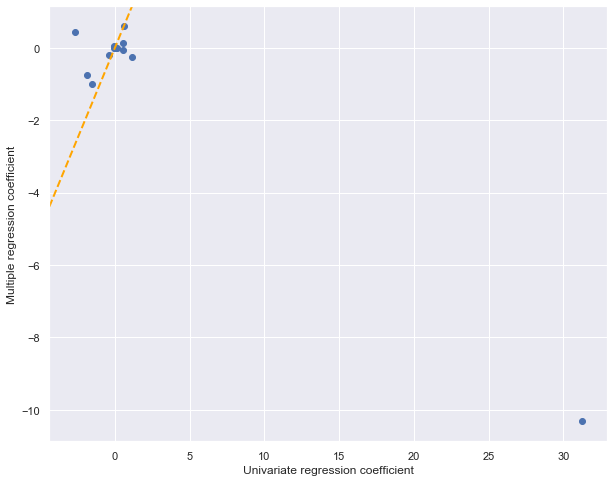

In [256]:
# Generate scatterplot
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(uni_reg_coeffs, multi_reg_coeffs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, color = "orange", linestyle = "--", linewidth = 2)
ax.set(xlabel = "Univariate regression coefficient", ylabel = "Multiple regression coefficient",
       xlim = xlim, ylim = ylim)

As we can see on the plot, some the coefficient estimates increased between the univariate regressions and the multiple regression for some of the predictors, as indicated by the fact that they lie above and to the left of the dashed blue line $y = x$. The rest, however, decreased, and one of them decreased by a rather large margin from around 30 to around -10. We can compare the coefficient estimates between the univariate regressions and the multiple regression in the data frame below. The coefficients that increased were for `CMEDV`, `ZN`, `CHAS`, `RM`, `DIS`, and `B`. The rest of the coefficients decreased.

In [257]:
multi_reg_se = all_reg["param_stats"].loc[1:13, "Standard Error"]

In [258]:
uni_reg_se = [linear_fits[pred]["param_stats"].loc[1, "Standard Error"] for pred in predictors]

[(-0.26763819922696713, 5.54946147047576),
 Text(0, 0.5, 'Multiple regression coefficient SE'),
 (-0.1539337116501521, 3.154971507380992),
 Text(0.5, 0, 'Univariate regression coefficient SE')]

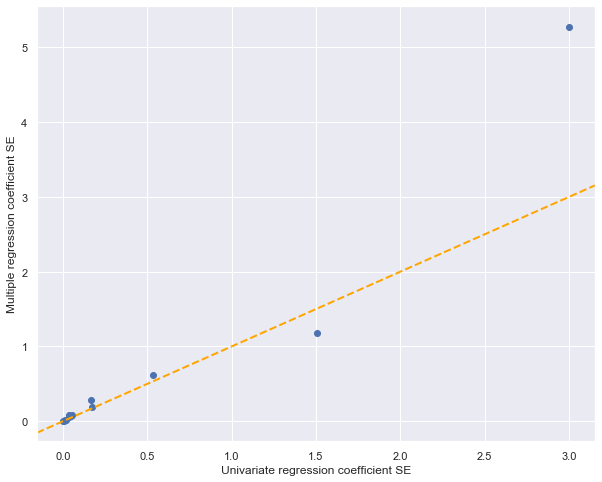

In [259]:
# Generate scatterplot
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(uni_reg_se, multi_reg_se)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, color = "orange", linestyle = "--", linewidth = 2)
ax.set(xlabel = "Univariate regression coefficient SE", ylabel = "Multiple regression coefficient SE",
       xlim = xlim, ylim = ylim)

In [260]:
pd.DataFrame({"Univariate coeff":uni_reg_coeffs, "Multivariate coeff":multi_reg_coeffs, 
              "Univariate SE": uni_reg_se, "Multivariate SE": multi_reg_se}).set_index(predictors)

,Univariate coeff,Multivariate coeff,Univariate SE,Multivariate SE
CMEDV,-0.364947,-0.199175,0.038430,0.061084
ZN,-0.073935,0.045140,0.016095,0.018752
INDUS,0.509776,-0.063335,0.051024,0.083425
CHAS,-1.892777,-0.747798,1.506115,1.180599
NOX,31.248531,-10.316158,2.999190,5.278149
RM,-2.684051,0.427040,0.532041,0.613260
AGE,0.107786,0.001429,0.012736,0.017928
DIS,-1.550902,-0.993058,0.168330,0.282614
RAD,0.617911,0.588018,0.034332,0.088074
TAX,0.029742,-0.003858,0.001847,0.005161


Since I was curious, I also explored how the standard error for the coefficient estimates changed between the univariate regressions and the multiple regressions. As we can see in the plot and above data frame, the standard error increased for all of the coefficients except for `CHAS` and `B` when going from univariate regression to multiple regression.

## Part 4
**Is there evidence of a non-linear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form**

\begin{equation}
    Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon.
\end{equation}

First, we note that attempting to perform polynomial regression of `CRIM` onto `CHAS` does not provide any additional information due to the fact that `CHAS` has just two values: 1 if the town borders the Charles River, and 0 otherwise. Therefore, we will exclude that predictor from this part. 

Similar to Applied Exercise 2 above, note that when doing this problem in R, we used the `poly()` function, which produces [*orthogonal polynomials*](https://en.wikipedia.org/wiki/Orthogonal_polynomials), and not raw ones. This is important because even though orthogonalizing the polynomials doesn't affect overall predictions the model will give, it reduces the correlation between the various powers of $X$ at the cost of sacrificing coefficient interpretability. Reducing the correlation between the powers improves our ability to interpret the t-statistics for each coeffiecient, because it alleviates the issue of multicollinearity. Since the PolynomialFeatures transformer in scikit-learn generates raw polynomials, we add an extra the orthogonalization step in order to better evaluate whether or not the inclusion of non-linear terms improves the model fit.

In [261]:
cubic_predictors = predictors.drop("CHAS")
cubic_fits = {}
for pred in cubic_predictors:
    poly = PolynomialFeatures(degree = 3, include_bias = True)
    pred_cubed = poly.fit_transform(boston[pred].values.reshape(-1, 1))
    # Orthogonalize the powers of the predictor using QR decomposition
    ortho_cubed = np.linalg.qr(pred_cubed)[0][:, 1:]
    reg = ExtendedLinearRegression(fit_intercept = True)
    cubic_fits[pred] = reg.detailed_linear_regression(ortho_cubed, boston["CRIM"].values.reshape(-1, 1))

In [262]:
np.round(cubic_fits["CMEDV"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.29110,12.41336,0.0
1,-75.30460,6.54812,-11.50018,0.0
2,88.53251,6.54812,13.52028,0.0
3,-48.26707,6.54812,-7.37113,0.0


In [263]:
np.round(cubic_fits["CMEDV"]["oa_stats"], 4)

Residual standard error      6.5481
R-squared                    0.4239
F-statistic                123.1286
F-test p-value               0.0000
dtype: float64

For the predictor `CMEDV`, we see that the coefficient estimates of all powers have p-values of essentially zero. Moreover, the cubic model has an $R^2$ value of 0.4239, which is an increase from the value of 0.1518 in the linear model. These two aspects provide strong evidence to suggest a non-linear association between the predictor `CMEDV` and the response `CRIM`.

In [264]:
np.round(cubic_fits["ZN"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.37219,9.70881,0.00000
1,-38.74984,8.37221,-4.62839,0.00000
2,-23.93983,8.37221,-2.85944,0.00442
3,-10.07187,8.37221,-1.20301,0.22954


In [265]:
np.round(cubic_fits["ZN"]["oa_stats"], 4)

Residual standard error     8.3722
R-squared                   0.0582
F-statistic                10.3485
F-test p-value              0.0000
dtype: float64

For the predictor `ZN`, we see that the coefficient estimate for $X^2$ has a p-value of 0.00442, which is strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$ at the 1% significance level. However, the coefficient estimate for $X^3$ has a p-value of 0.22954, which isn't sufficient evidence to reject the null hypothesis $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.0582, which is a slight increase from the value of 0.04019 in the linear model. These two aspects provide some evidence to suggest a non-linear association between the predictor `ZN` and the response `CRIM`, but it is not strong evidence.

In [266]:
np.round(cubic_fits["INDUS"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.33000,10.95014,0.00000
1,78.59082,7.42312,10.58730,0.00000
2,-24.39480,7.42312,-3.28633,0.00109
3,-54.12976,7.42312,-7.29205,0.00000


In [267]:
np.round(cubic_fits["INDUS"]["oa_stats"], 4)

Residual standard error     7.4231
R-squared                   0.2597
F-statistic                58.6883
F-test p-value              0.0000
dtype: float64

For the predictor `INDUS`, we see that the coefficient estimates of all powers have p-values of close to zero, though the coefficient estimate for $X^2$ has a p-value, at 0.00109, isn't small enough to be essentially zero. Moreover, the cubic model has an $R^2$ value of 0.2597, which is an increase from the value of 0.1653 in the linear model. These two aspects provide strong evidence to suggest a non-linear association between the predictor `INDUS` and the response `CRIM`.

In [268]:
np.round(cubic_fits["NOX"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.32157,11.23703,0.00000
1,81.37202,7.23361,11.24916,0.00000
2,28.82859,7.23361,3.98537,0.00008
3,60.36189,7.23361,8.34465,0.00000


In [269]:
np.round(cubic_fits["NOX"]["oa_stats"], 4)

Residual standard error     7.2336
R-squared                   0.2970
F-statistic                70.6867
F-test p-value              0.0000
dtype: float64

For the predictor `NOX`, we see that the coefficient estimates of all powers have p-values of essentially zero. Moreover, the cubic model has an $R^2$ value of 0.2970, which is an increase from the value of 0.1772 in the linear model. These two aspects provide strong evidence to suggest a non-linear association between the predictor `NOX` and the response `CRIM`.

In [270]:
np.round(cubic_fits["RM"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.37030,9.75839,0.00000
1,42.37944,8.32968,5.08777,0.00000
2,-26.57677,8.32968,-3.19061,0.00151
3,-5.51034,8.32968,-0.66153,0.50857


In [271]:
np.round(cubic_fits["RM"]["oa_stats"], 4)

Residual standard error     8.3297
R-squared                   0.0678
F-statistic                12.1677
F-test p-value              0.0000
dtype: float64

For the predictor `RM`, we see that the coefficient estimate for $X^2$ has a p-value of 0.00151, which is strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$ at the 1% significance level. However, the coefficient estimate for $X^3$ has a p-value of 0.50858, which isn't sufficient evidence to reject the null hypothesis $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.0678, which is a slight increase from the value of 0.04807 in the linear model. These two aspects provide some evidence to suggest a non-linear association between the predictor `RM` and the response `CRIM`, but it is not strong evidence.

In [272]:
np.round(cubic_fits["AGE"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.34852,10.36828,0.00000
1,-68.18201,7.83970,-8.69701,0.00000
2,37.48447,7.83970,4.78136,0.00000
3,-21.35321,7.83970,-2.72373,0.00668


In [273]:
np.round(cubic_fits["AGE"]["oa_stats"], 4)

Residual standard error     7.8397
R-squared                   0.1742
F-statistic                35.3061
F-test p-value              0.0000
dtype: float64

For the predictor `AGE`, we see that the coefficient estimate for $X^2$ has a p-value of essentially zero, which is strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$. In addition, the coefficient estimate for $X^3$ has a p-value of 0.00668, which is evidence to reject the null hypothesis $H_0: \beta_3 = 0$ at the 1% level. Moreover, the cubic model has an $R^2$ value of 0.1742, which is a modest increase from the value of 0.1244 in the linear model. These two aspects provide some evidence to suggest a non-linear association between the predictor `AGE` and the response `CRIM`.

In [274]:
np.round(cubic_fits["DIS"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.32592,11.08701,0.0
1,73.38859,7.33148,10.01007,0.0
2,56.37304,7.33148,7.68918,0.0
3,-42.62188,7.33148,-5.81354,0.0


In [275]:
np.round(cubic_fits["DIS"]["oa_stats"], 4)

Residual standard error     7.3315
R-squared                   0.2778
F-statistic                64.3741
F-test p-value              0.0000
dtype: float64

For the predictor `DIS`, we see that the coefficient estimates of all powers have p-values of essentially zero. Moreover, the cubic model has an $R^2$ value of 0.2778, which is an increase from the value of 0.1441 in the linear model. These two aspects provide strong evidence to suggest a non-linear association between the predictor `DIS` and the response `CRIM`.

In [276]:
np.round(cubic_fits["RAD"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.29707,12.16392,0.00000
1,120.90745,6.68240,18.09341,0.00000
2,-17.49230,6.68240,-2.61767,0.00912
3,-4.69846,6.68240,-0.70311,0.48231


In [277]:
np.round(cubic_fits["RAD"]["oa_stats"], 4)

Residual standard error      6.6824
R-squared                    0.4000
F-statistic                111.5727
F-test p-value               0.0000
dtype: float64

For the predictor `RAD`, we see that the coefficient estimate for $X^2$ has a p-value of 0.00912, which is just barely enough evidence to reject the null hypothesis $H_0: \beta_2 = 0$ at the 1% significance level. However, the coefficient estimate for $X^3$ has a p-value of 0.48231, which isn't sufficient evidence to reject the null hypothesis $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.4000, which is only a slight increase from the value of 0.3913 in the linear model. These two aspects provide evidence to suggest that there isn't a non-linear association between the predictor `RAD` and the response `CRIM`. In other words, it appears that the linear model is a better representation of the association between `RAD` and `CRIM`.

In [278]:
np.round(cubic_fits["TAX"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.30468,11.85989,0.00000
1,112.64583,6.85371,16.43575,0.00000
2,-32.08725,6.85371,-4.68174,0.00000
3,-7.99681,6.85371,-1.16679,0.24385


In [279]:
np.round(cubic_fits["TAX"]["oa_stats"], 4)

Residual standard error     6.8537
R-squared                   0.3689
F-statistic                97.8047
F-test p-value              0.0000
dtype: float64

For the predictor `TAX`, we see that the coefficient estimate for $X^2$ has a p-value of essentially zero, which is strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$. However, the coefficient estimate for $X^3$ has a p-value of 0.244, which isn't sufficient evidence to reject the null hypothesis $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.3689, which is a modest increase from the value of 0.3396 in the linear model. These two aspects provide some evidence to suggest a non-linear association between the predictor `TAX` and the response `CRIM`, but it is not strong evidence.

In [280]:
np.round(cubic_fits["PTRATIO"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.36105,10.00842,0.0000
1,56.04523,8.12158,6.90078,0.0000
2,24.77482,8.12158,3.05049,0.0024
3,-22.27974,8.12158,-2.74328,0.0063


In [281]:
np.round(cubic_fits["PTRATIO"]["oa_stats"], 4)

Residual standard error     8.1216
R-squared                   0.1138
F-statistic                21.4839
F-test p-value              0.0000
dtype: float64

For the predictor `PTRATIO`, we see that the coefficient estimate for $X^2$ has a p-value of 0.00241, which is strong evidence to reject the null hypothesis $H_0: \beta_2 = 0$ at the 1% significance level. In addition, the coefficient estimate for $X^3$ has a p-value of 0.00630, which is evidence to reject the null hypothesis $H_0: \beta_3 = 0$ at the 1% level as well. Moreover, the cubic model has an $R^2$ value of 0.1138, which is a modest increase from the value of 0.08407 in the linear model. These two aspects provide some evidence to suggest a non-linear association between the predictor `PTRATIO` and the response `CRIM`.

In [282]:
np.round(cubic_fits["B"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.35363,10.21846,0.00000
1,74.43120,7.95464,9.35695,0.00000
2,-5.92642,7.95464,-0.74503,0.45660
3,4.83457,7.95464,0.60777,0.54362


In [283]:
np.round(cubic_fits["B"]["oa_stats"], 4)

Residual standard error     7.9546
R-squared                   0.1498
F-statistic                29.4923
F-test p-value              0.0000
dtype: float64

For the predictor `B`, we see that the coefficient estimates for $X^2$ and $X^3$ have p-values exceeding 0.45. This means there isn't any evidence to reject the null hypotheses $H_0: \beta_2 = 0$ and $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.1498, which is only a tiny increase from the value of 0.1483 in the linear model. These two aspects provide strong evidence to suggest that there isn't a non-linear association between the predictor `B` and the response `CRIM`. In other words, it appears that the linear model is a better representation of the association between `B` and `CRIM`.

In [284]:
np.round(cubic_fits["LSTAT"]["param_stats"], 5)

,Coefficient,Standard Error,t-value,Prob(>|t|)
0,3.61352,0.33917,10.65402,0.00000
1,88.06967,7.62944,11.54340,0.00000
2,-15.88816,7.62944,-2.08248,0.03780
3,-11.57402,7.62944,-1.51702,0.12989


In [285]:
np.round(cubic_fits["LSTAT"]["oa_stats"], 4)

Residual standard error     7.6294
R-squared                   0.2179
F-statistic                46.6294
F-test p-value              0.0000
dtype: float64

For the predictor `LSTAT`, we see that the coefficient estimate for $X^2$ has a p-value of 0.0378, which is just enough evidence to reject the null hypothesis $H_0: \beta_2 = 0$ at the 5% significance level. However, the coefficient estimate for $X^3$ has a p-value of 0.1299, which isn't sufficient evidence to reject the null hypothesis $H_0: \beta_3 = 0$. Moreover, the cubic model has an $R^2$ value of 0.2179, which is only a slight increase from the value of 0.2076 in the linear model. These two aspects provide evidence to suggest that there isn't a non-linear association between the predictor `LSTAT` and the response `CRIM`. In other words, it appears that the linear model is a better representation of the association between `LSTAT` and `CRIM`.

In summary, we can group the predictors into three categores: those for which there is strong evidence of a non-linear relationship (cubic in this case) with the response, those for which there is some evidence of a non-linear relationship (though not strong evidence), and those for which there is no evidence of a non-linear relationship. The predictors `CMEDV`, `INDUS`, `NOX`, and `DIS` fall into the first group; `ZN`, `RM`, `AGE`, `TAX`, and `PTRATIO` fall into the second group; `RAD`, `B` and `LSTAT` fall into the last group.

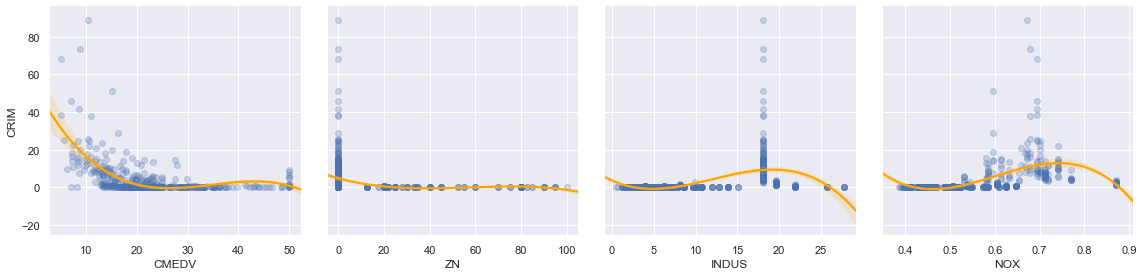

In [286]:
g = sns.PairGrid(boston, x_vars = cubic_predictors[:4], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, order = 3, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})

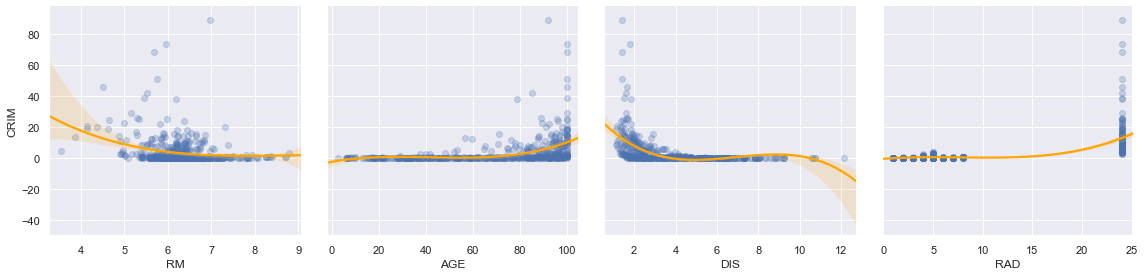

In [287]:
g = sns.PairGrid(boston, x_vars = cubic_predictors[4:8], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, order = 3, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})

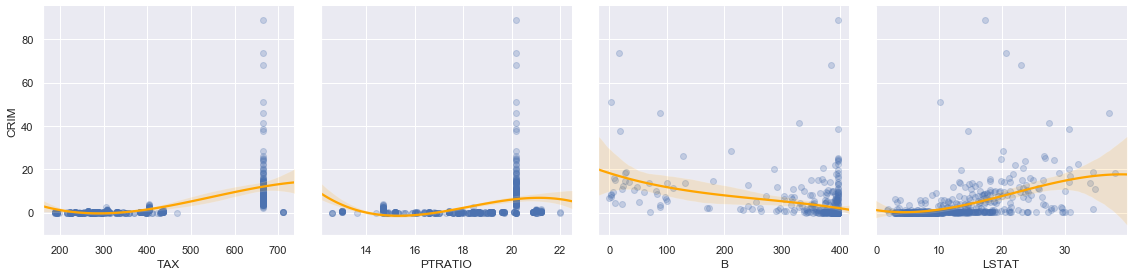

In [288]:
g = sns.PairGrid(boston, x_vars = predictors[9:13], y_vars = ["CRIM"], height = 4)
g.map(sns.regplot, order = 3, scatter_kws = {"alpha":0.25}, line_kws = {"color": "orange"})